#### Para usar desde colab

In [1]:
#Colab = True
Colab = False

- Montamos google drive

In [2]:
if Colab:
    from google.colab import drive
    drive.mount('/content/drive')

- Creamos los directorios

In [3]:
if Colab == True:

    import os

    computerscreen_dataset = "/content/drive/MyDrive/computerscreen_dataset"
    train = "/content/drive/MyDrive/computerscreen_dataset/train"
    valid = "/content/drive/MyDrive/computerscreen_dataset/valid"
    test = "/content/drive/MyDrive/computerscreen_dataset/test"

    os.mkdir(computerscreen_dataset)
    os.mkdir(train)
    os.mkdir(valid)
    os.mkdir(test)

- Extraemos los archivos que tenemos en drive

In [4]:
if Colab == True:
    from pathlib import Path
    !unrar x /content/drive/MyDrive/train.rar -o+ /content/drive/MyDrive/computerscreen_dataset/train
    !unrar x /content/drive/MyDrive/valid.rar -o+ /content/drive/MyDrive/computerscreen_dataset/valid
    !unrar x /content/drive/MyDrive/test.rar -o+ /content/drive/MyDrive/computerscreen_dataset/test

#### Librerias

In [5]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import transforms
import math
from PIL import Image
#import albumentations as A
from tqdm import tqdm
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import sys
%matplotlib inline

#### Datos

In [6]:
# leemos el archivo de anotaciones
if Colab:
  with open('/content/drive/MyDrive/computerscreen_dataset/train/_annotations.coco.json') as file:
    data = json.load(file)
else:
  with open('./computerscreen_dataset/train/_annotations.coco.json') as file:
      data = json.load(file)

In [7]:
data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [8]:
data['images'][:3]

[{'id': 0,
  'license': 1,
  'file_name': 'download-37-_jpg.rf.e5b34ffc358e91827e327f604c544e6e.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-02-07T13:41:44+00:00'},
 {'id': 1,
  'license': 1,
  'file_name': 'images-52-_jpg.rf.e625c8cd34a0e15cfe3b14381b125c29.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-02-07T13:41:44+00:00'},
 {'id': 2,
  'license': 1,
  'file_name': 'images-39-_jpg.rf.e6945e0c418e3abc30ceab10ece55f1c.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-02-07T13:41:44+00:00'}]

In [9]:
data['annotations'][:3]

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'bbox': [3, 159, 637, 428.5],
  'area': 272954.5,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 1,
  'category_id': 1,
  'bbox': [1, 173, 611, 327],
  'area': 199797,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 2,
  'category_id': 1,
  'bbox': [0, 247, 387, 314],
  'area': 121518,
  'segmentation': [],
  'iscrowd': 0}]

In [10]:
ids_value = [item['image_id'] for item in data['annotations'][:3]]

In [11]:
[item['bbox'] for item in data['annotations'] if item['image_id'] == 2]

[[0, 247, 387, 314], [326, 405, 177, 154.5]]

#### Creamos el dataset

In [12]:
class ScreenDataset(torch.utils.data.Dataset):

    def __init__(self, root: str, transforms: None) -> None:

        super().__init__()

        # ruta al directorio raiz
        self.root = root
        # path al archivo con las anotaciones
        self.annotations_path = os.path.join(root, "_annotations.coco.json")
        # transformaciones
        self.transforms = transforms

        with open(self.annotations_path, 'r') as file:
            data = json.load(file)

        self.data = data

        # indices y nombres de las imagenes
        self.idx_images = [item['id'] for item in self.data['images']]
        self.name_images = [item['file_name'] for item in self.data['images']]

    def _load_image(self, name: str) -> Image.Image:

        # Leemos la imagen
        image = Image.open(os.path.join(self.root, name))

        return image

    def __getitem__(self, index: int):

        # id y nombre de la imagen
        id = self.idx_images[index]
        name = self.name_images[index]

        # cargamos la imagen
        image = self._load_image(name)

        # cargamos los bboxes
        bboxes = [item['bbox'] for item in self.data['annotations'] if item['image_id'] == id]
        # cargamos las areas
        area  = [item['area'] for item in self.data['annotations'] if item['image_id'] == id]
        # labels (Siempre pantallas)
        labels = [item['category_id'] for item in self.data['annotations'] if item['image_id'] == id]
        # iscrowd
        iscrowd = [item['iscrowd'] for item in self.data['annotations'] if item['image_id'] == id]

        if self.transforms is not None:
            image = self.transforms(image)

        # transformamos el formato coco a coordenadas "normales"
        boxes = []
        for box in bboxes:
            xmin =  box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            #xmax = box[2]
            #ymax = box[3]
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.tensor(id)
        target["area"] = torch.tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.tensor(iscrowd, dtype=torch.int64)

        return image, target

    def __len__(self) -> int:
        return len(self.idx_images)

In [13]:
# path a los datasets
if Colab:
  root = "/content/drive/MyDrive/computerscreen_dataset/"
else:
  root = "./computerscreen_dataset/"

# transformaciones a aplicar
train_transform = transforms.Compose([
  transforms.Resize(640),
  transforms.ToTensor(), # convertimos a tensor
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  #torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
  transforms.Lambda(lambda x: x.clamp(0, 1)), # limitamos los valores entre 0 y 1
])

valid_transform = transforms.Compose([
  transforms.Resize(640),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  transforms.Lambda(lambda x: x.clamp(0, 1))
])

train_dataset = ScreenDataset(root + "train/", transforms=train_transform)
valid_dataset = ScreenDataset(root + "valid/", transforms=valid_transform)
test_dataset = ScreenDataset(root + "test/", transforms=valid_transform)

def collate_fn(batch):
  return tuple(zip(*batch))

# Create data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collate_fn)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

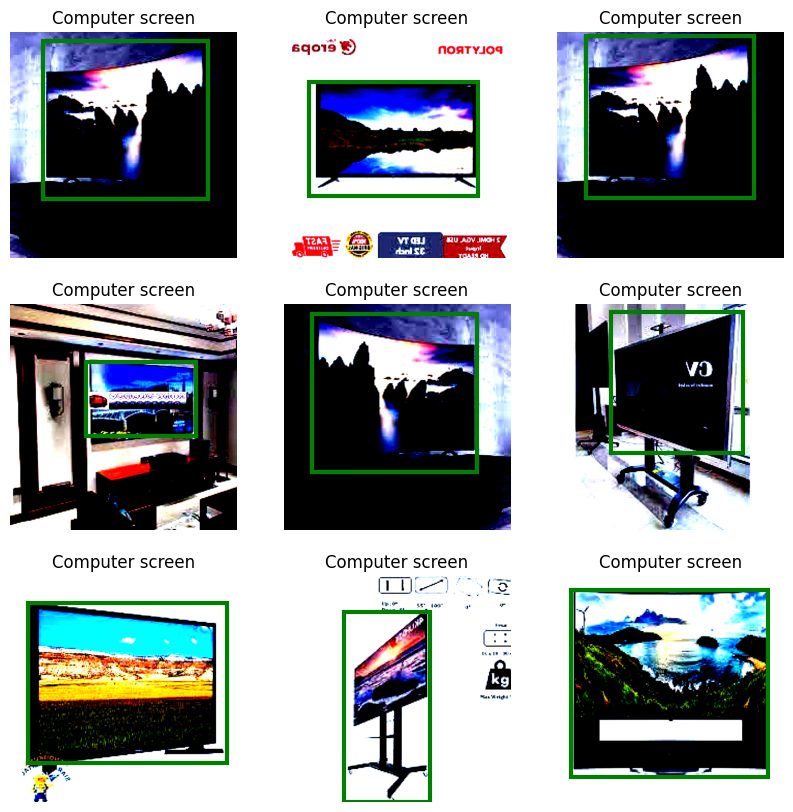

In [14]:
#figure = plt.figure(figsize = (10,10))
fig, ax = plt.subplots(3, 3, figsize = (10,10))
ax = ax.flatten()

cols, rows = 3, 3

for i in range (0, cols*rows):

    sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
    target = train_dataset[sample_idx]
    #print(boxes)
    ax[i].set_title("Computer screen")
    ax[i].axis('off')
    ax[i].imshow(target[0].permute(1, 2, 0))

    for box in target[1]['boxes']:
        x, y, w, h = box
        rect = patches.Rectangle((int(x), int(y)), int(w) - int(x), int(h) - int(y), linewidth=3, edgecolor='g', facecolor='none')
        ax[i].add_patch(rect)

plt.show()

#### Elegimos dispositivo

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

#### Modelo

In [16]:
MovilNetV3 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=None)
MovilNetV3.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [17]:
MovilNetV3.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [18]:
MovilNetV3.roi_heads.box_predictor.cls_score

Linear(in_features=1024, out_features=91, bias=True)

In [19]:
# Modificamos la ultima capa para que solo haya una clase de salida
#MovilNetV3.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
# para una clase solo necesitamso 4 coordenadas
#MovilNetV3.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features=1024, out_features=4, bias=True)
#MovilNetV3

In [20]:
num_classes = 2  # 1 class (TV) + background
# get number of input features for the classifier
in_features = MovilNetV3.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
MovilNetV3.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
MovilNetV3.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Número de parámetros: {count_parameters(MovilNetV3)}')

Número de parámetros: 18871333


#### Optimizador

In [22]:
optimizer = torch.optim.SGD(MovilNetV3.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)
#optimizer = torch.optim.Adam(MovilNetV3.parameters(), lr=1e-3, weight_decay=1e-2)

#### Función de validación y entrenamiento

In [23]:
def train(model, optimizer, loader, device):

    # ponemos el modelo en modo entrenamiento
    model.train()

    # variable para almacenar el error
    all_losses = []
    all_losses_dict = []

    # recorremos el dataset
    for batch, (images, targets) in tqdm(enumerate(loader)):

        # ponemos en dispositivo
        #images = images.to(device)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values()) # se suman todas la perdidas ¿Son sumables?
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()} # los mismo que loss_dict pero no son tensores.
        losses_reduced = sum(loss for loss in loss_dict.values()) # losses_reduced y losses es lo mismo
        loss_value = losses_reduced.item()
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        # backward
        #loss.backward()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    return all_losses_dict, all_losses

In [24]:
# https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    # ALMACENAMOS LAS DIMENSIONES DE LAS IMAGENES, NO HARÍA FALTA, PORQUE LA CLASE DATASET
    # TRANSFORMA TODAS LAS IMAGENES A 640X640, ADEMAS EL DATASET YA VIENE EN 640X640
    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    # APLICAMOS LAS TRANSFORMACIONES A LAS IMAGENES Y TARGETS (ME PARECE QUE NO HACE FALTA,
    # YA QUE LO HACEMOS EN LA CLASE DATASET)
    images, targets = model.transform(images, targets)

    # NOS FIJAMOS SI HAY ALGUNA CAJA CON COORDENADAS INCORRECTAS
    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    # EL BACKBONE ES COMO LA COLUMNA VERTEBRAL DE LOS DETECTORES DE OBJETOS, ES LA PARTE DE LA RED NEURONAL
    # QUE EXTRAE LAS CARACTERISTICAS SIGNIFICATIVAS DE LAS IMAGENES.
    # SI "features" es tensor entonces lo almacenamos en un diccionario ordenado
    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True # la parte rpn del modelo la ponemos en modo entrenamiento, ya que algunas capas
    # del modelo puede tener comportamientos distintos en .eval() y .train() (por ejemplo, Dropout y BatchNorm).
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values()) # ponemos los valores del dict en una lista
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn) # obtenemos las puntuaciones
    # de objetividad y las deltas de las cajas delimitadoras
    anchors = model.rpn.anchor_generator(images, features_rpn) # generamos un conjunto de anchors

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [25]:
def valid(model, loader, device):

    # ponemos el modelo en modo entrenamiento
    model.eval() # si ponemos el modelo en evaluación no devolvera las perdidas, devuelve los bboxes, scores y labels.

    # variable para almacenar el error
    all_losses = []
    all_losses_dict = []

    # evitamos el uso del gradiente
    with torch.no_grad():

        # recorremos el dataset
        for batch, (images, targets) in tqdm(enumerate(loader)):

            # ponemos en dispositivo
            images = list(image.to(device) for image in images)
            targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

            # forward
            loss_dict, _ = eval_forward(model, images, targets)


            # forward
            loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
            losses_reduced = sum(loss for loss in loss_dict.values())
            loss_value = losses_reduced.item()
            all_losses.append(loss_value)
            all_losses_dict.append(loss_dict_append)

    return all_losses_dict, all_losses

#### Entrenamos

In [49]:
epochs = 50
best_val_loss = float('inf')

# diccionarios para almacenar los errores
train_loss_dict = {
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_rpn_box_reg': [],
    'loss_objectness': [],
}
valid_loss_dict = {
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_rpn_box_reg': [],
    'loss_objectness': [],
}
# listas para guardar los errores totales
valid_all_losses = []
train_all_losses = []

for epoch in range(epochs):

    train_loss, all_losses_train = train(MovilNetV3, optimizer, train_loader, device)
    val_loss, all_losses_valid = valid(MovilNetV3, valid_loader, device)

    # convertimos a dataframe
    train_loss_pd = pd.DataFrame(train_loss)
    valid_loss_pd = pd.DataFrame(val_loss)

    # almacenamos
    train_loss_dict['loss_classifier'].append(train_loss_pd["loss_classifier"].mean())
    train_loss_dict['loss_box_reg'].append(train_loss_pd["loss_box_reg"].mean())
    train_loss_dict['loss_rpn_box_reg'].append(train_loss_pd["loss_rpn_box_reg"].mean())
    train_loss_dict['loss_objectness'].append(train_loss_pd["loss_objectness"].mean())
    valid_loss_dict['loss_classifier'].append(valid_loss_pd["loss_classifier"].mean())
    valid_loss_dict['loss_box_reg'].append(valid_loss_pd["loss_box_reg"].mean())
    valid_loss_dict['loss_rpn_box_reg'].append(valid_loss_pd["loss_rpn_box_reg"].mean())
    valid_loss_dict['loss_objectness'].append(valid_loss_pd["loss_objectness"].mean())
    train_all_losses.append(all_losses_train)
    valid_all_losses.append(all_losses_valid)


    # Imprimimos algunos detalles en pantalla
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'TRAIN: ')
    print("loss_classifier", train_loss_pd["loss_classifier"].mean())
    print("loss_rpn_box_reg", train_loss_pd["loss_rpn_box_reg"].mean())
    print("loss_rpn_box_reg", train_loss_pd["loss_rpn_box_reg"].mean())
    print("loss_objectness", train_loss_pd["loss_objectness"].mean())
    print(f"Perdida total: {sum(all_losses_train) / len(all_losses_train)}")
    print(f'VALID: ')
    print("loss_classifier", valid_loss_pd["loss_classifier"].mean())
    print("loss_rpn_box_reg", valid_loss_pd["loss_rpn_box_reg"].mean())
    print("loss_rpn_box_reg", valid_loss_pd["loss_rpn_box_reg"].mean())
    print("loss_objectness", valid_loss_pd["loss_objectness"].mean())
    print(f"Perdida total: {sum(all_losses_valid) / len(all_losses_valid)}")
    total = sum(all_losses_valid) / len(all_losses_valid)
    # almacenamos el modelo
    if total < best_val_loss:
        best_val_loss = total
        torch.save(MovilNetV3.state_dict(), f"Movilnet{epoch}.pt")

7it [00:23,  3.29s/it]
0it [00:00, ?it/s]<ipython-input-48-f36895837812>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
1it [00:01,  1.79s/it]


Epoch 1/50
TRAIN: 
loss_classifier 0.6020776586873191
loss_rpn_box_reg 0.011612799018621445
loss_rpn_box_reg 0.011612799018621445
loss_objectness 0.6859006030218942
Perdida total: 1.5324500969478063
VALID: 
loss_classifier 0.45595061779022217
loss_rpn_box_reg 0.012577502988278866
loss_rpn_box_reg 0.012577502988278866
loss_objectness 0.6831263899803162
Perdida total: 1.39206063747406


7it [00:23,  3.29s/it]
1it [00:01,  1.66s/it]


Epoch 2/50
TRAIN: 
loss_classifier 0.3569305326257433
loss_rpn_box_reg 0.011085891430931432
loss_rpn_box_reg 0.011085891430931432
loss_objectness 0.6791647928101676
Perdida total: 1.277120930807931
VALID: 
loss_classifier 0.28130823373794556
loss_rpn_box_reg 0.012735768221318722
loss_rpn_box_reg 0.012735768221318722
loss_objectness 0.6733970642089844
Perdida total: 1.2097679376602173


7it [00:23,  3.31s/it]
1it [00:01,  1.68s/it]


Epoch 3/50
TRAIN: 
loss_classifier 0.2683889312403543
loss_rpn_box_reg 0.011155647624816214
loss_rpn_box_reg 0.011155647624816214
loss_objectness 0.6668952277728489
Perdida total: 1.175486615725926
VALID: 
loss_classifier 0.26761841773986816
loss_rpn_box_reg 0.01257600262761116
loss_rpn_box_reg 0.01257600262761116
loss_objectness 0.6592370271682739
Perdida total: 1.1758440732955933


7it [00:24,  3.44s/it]
1it [00:01,  1.68s/it]


Epoch 4/50
TRAIN: 
loss_classifier 0.25992789438792635
loss_rpn_box_reg 0.010471830410616738
loss_rpn_box_reg 0.010471830410616738
loss_objectness 0.6520067197935921
Perdida total: 1.150214501789638
VALID: 
loss_classifier 0.24667763710021973
loss_rpn_box_reg 0.012105157598853111
loss_rpn_box_reg 0.012105157598853111
loss_objectness 0.6445476412773132
Perdida total: 1.1376972198486328


7it [00:23,  3.35s/it]
1it [00:01,  1.68s/it]


Epoch 5/50
TRAIN: 
loss_classifier 0.2282015255519322
loss_rpn_box_reg 0.009918177766459329
loss_rpn_box_reg 0.009918177766459329
loss_objectness 0.6373532840183803
Perdida total: 1.1033588647842407
VALID: 
loss_classifier 0.21930056810379028
loss_rpn_box_reg 0.011730401776731014
loss_rpn_box_reg 0.011730401776731014
loss_objectness 0.6299402713775635
Perdida total: 1.0979278087615967


7it [00:22,  3.22s/it]
1it [00:01,  1.70s/it]


Epoch 6/50
TRAIN: 
loss_classifier 0.20539078755038126
loss_rpn_box_reg 0.00966790531362806
loss_rpn_box_reg 0.00966790531362806
loss_objectness 0.6221718277250018
Perdida total: 1.065434558050973
VALID: 
loss_classifier 0.20480181276798248
loss_rpn_box_reg 0.01164071261882782
loss_rpn_box_reg 0.01164071261882782
loss_objectness 0.6129213571548462
Perdida total: 1.0660812854766846


7it [00:23,  3.36s/it]
1it [00:01,  1.99s/it]


Epoch 7/50
TRAIN: 
loss_classifier 0.1926319577864238
loss_rpn_box_reg 0.009252057942960943
loss_rpn_box_reg 0.009252057942960943
loss_objectness 0.6036595702171326
Perdida total: 1.0334653173174178
VALID: 
loss_classifier 0.19641847908496857
loss_rpn_box_reg 0.01178845576941967
loss_rpn_box_reg 0.01178845576941967
loss_objectness 0.5920366048812866
Perdida total: 1.0434311628341675


7it [00:22,  3.21s/it]
1it [00:01,  1.82s/it]


Epoch 8/50
TRAIN: 
loss_classifier 0.18092643576008932
loss_rpn_box_reg 0.009416503432605947
loss_rpn_box_reg 0.009416503432605947
loss_objectness 0.5787429213523865
Perdida total: 0.9934628180095127
VALID: 
loss_classifier 0.18779364228248596
loss_rpn_box_reg 0.012047871947288513
loss_rpn_box_reg 0.012047871947288513
loss_objectness 0.5649367570877075
Perdida total: 1.0109715461730957


7it [00:23,  3.33s/it]
1it [00:01,  1.77s/it]


Epoch 9/50
TRAIN: 
loss_classifier 0.16765884842191422
loss_rpn_box_reg 0.009003195246415479
loss_rpn_box_reg 0.009003195246415479
loss_objectness 0.5472903166498456
Perdida total: 0.9422154767172677
VALID: 
loss_classifier 0.1750493347644806
loss_rpn_box_reg 0.01245350856333971
loss_rpn_box_reg 0.01245350856333971
loss_objectness 0.5283350348472595
Perdida total: 0.9499173164367676


7it [00:23,  3.30s/it]
1it [00:01,  1.66s/it]


Epoch 10/50
TRAIN: 
loss_classifier 0.1591984714780535
loss_rpn_box_reg 0.00925585241722209
loss_rpn_box_reg 0.00925585241722209
loss_objectness 0.5065337078911918
Perdida total: 0.8932956457138062
VALID: 
loss_classifier 0.16573874652385712
loss_rpn_box_reg 0.012914998456835747
loss_rpn_box_reg 0.012914998456835747
loss_objectness 0.48059898614883423
Perdida total: 0.8923596143722534


7it [00:22,  3.24s/it]
1it [00:01,  1.69s/it]


Epoch 11/50
TRAIN: 
loss_classifier 0.14342040036405837
loss_rpn_box_reg 0.009433194728834289
loss_rpn_box_reg 0.009433194728834289
loss_objectness 0.4516362931047167
Perdida total: 0.8137532898357936
VALID: 
loss_classifier 0.1527399867773056
loss_rpn_box_reg 0.013344460166990757
loss_rpn_box_reg 0.013344460166990757
loss_objectness 0.4129450023174286
Perdida total: 0.8105452656745911


7it [00:22,  3.24s/it]
1it [00:01,  1.67s/it]


Epoch 12/50
TRAIN: 
loss_classifier 0.13042931684425899
loss_rpn_box_reg 0.009842612115400178
loss_rpn_box_reg 0.009842612115400178
loss_objectness 0.3742872604301998
Perdida total: 0.717848036970411
VALID: 
loss_classifier 0.13872165977954865
loss_rpn_box_reg 0.013874029740691185
loss_rpn_box_reg 0.013874029740691185
loss_objectness 0.321776807308197
Perdida total: 0.6977976560592651


7it [00:22,  3.20s/it]
1it [00:01,  1.74s/it]


Epoch 13/50
TRAIN: 
loss_classifier 0.11075352451631001
loss_rpn_box_reg 0.011095853123281683
loss_rpn_box_reg 0.011095853123281683
loss_objectness 0.2817476434367044
Perdida total: 0.586401777608054
VALID: 
loss_classifier 0.11538654565811157
loss_rpn_box_reg 0.014969664625823498
loss_rpn_box_reg 0.014969664625823498
loss_objectness 0.21707352995872498
Perdida total: 0.5440176129341125


7it [00:22,  3.19s/it]
1it [00:01,  1.93s/it]


Epoch 14/50
TRAIN: 
loss_classifier 0.0892956576177052
loss_rpn_box_reg 0.012807166736040796
loss_rpn_box_reg 0.012807166736040796
loss_objectness 0.19138778959001815
Perdida total: 0.4358505734375545
VALID: 
loss_classifier 0.1008787676692009
loss_rpn_box_reg 0.016643013805150986
loss_rpn_box_reg 0.016643013805150986
loss_objectness 0.1415310502052307
Perdida total: 0.4102325737476349


7it [00:20,  2.91s/it]
1it [00:01,  1.52s/it]


Epoch 15/50
TRAIN: 
loss_classifier 0.08886399226529258
loss_rpn_box_reg 0.014448321291378565
loss_rpn_box_reg 0.014448321291378565
loss_objectness 0.14107574628932135
Perdida total: 0.37349916781697956
VALID: 
loss_classifier 0.12170004844665527
loss_rpn_box_reg 0.018332775682210922
loss_rpn_box_reg 0.018332775682210922
loss_objectness 0.10727041214704514
Perdida total: 0.4047948718070984


7it [00:19,  2.75s/it]
1it [00:01,  1.47s/it]


Epoch 16/50
TRAIN: 
loss_classifier 0.09886772079127175
loss_rpn_box_reg 0.014395130798220634
loss_rpn_box_reg 0.014395130798220634
loss_objectness 0.123081593641213
Perdida total: 0.37216379387038095
VALID: 
loss_classifier 0.1226959377527237
loss_rpn_box_reg 0.017839163541793823
loss_rpn_box_reg 0.017839163541793823
loss_objectness 0.09396155923604965
Perdida total: 0.4103543758392334


7it [00:17,  2.51s/it]
1it [00:01,  1.80s/it]


Epoch 17/50
TRAIN: 
loss_classifier 0.10154929969991956
loss_rpn_box_reg 0.013567893632820674
loss_rpn_box_reg 0.013567893632820674
loss_objectness 0.11875801001276289
Perdida total: 0.37642485754830496
VALID: 
loss_classifier 0.11998707801103592
loss_rpn_box_reg 0.017634740099310875
loss_rpn_box_reg 0.017634740099310875
loss_objectness 0.09050291031599045
Perdida total: 0.41521453857421875


7it [00:17,  2.52s/it]
1it [00:01,  1.75s/it]


Epoch 18/50
TRAIN: 
loss_classifier 0.09961977920361928
loss_rpn_box_reg 0.01231964211910963
loss_rpn_box_reg 0.01231964211910963
loss_objectness 0.10779160154717309
Perdida total: 0.3657414530004774
VALID: 
loss_classifier 0.12162923067808151
loss_rpn_box_reg 0.016911208629608154
loss_rpn_box_reg 0.016911208629608154
loss_objectness 0.08806101232767105
Perdida total: 0.4138765335083008


7it [00:17,  2.45s/it]
1it [00:01,  1.46s/it]


Epoch 19/50
TRAIN: 
loss_classifier 0.09442557500941413
loss_rpn_box_reg 0.012172064876982145
loss_rpn_box_reg 0.012172064876982145
loss_objectness 0.10564188020569938
Perdida total: 0.3507510381085532
VALID: 
loss_classifier 0.11609659343957901
loss_rpn_box_reg 0.01720401830971241
loss_rpn_box_reg 0.01720401830971241
loss_objectness 0.0831245630979538
Perdida total: 0.3942818343639374


7it [00:17,  2.44s/it]
1it [00:01,  1.73s/it]


Epoch 20/50
TRAIN: 
loss_classifier 0.09184652354036059
loss_rpn_box_reg 0.011235616569008147
loss_rpn_box_reg 0.011235616569008147
loss_objectness 0.09715365618467331
Perdida total: 0.3369432432310922
VALID: 
loss_classifier 0.12125701457262039
loss_rpn_box_reg 0.016317177563905716
loss_rpn_box_reg 0.016317177563905716
loss_objectness 0.07791104167699814
Perdida total: 0.4053308963775635


7it [00:17,  2.48s/it]
1it [00:01,  1.45s/it]


Epoch 21/50
TRAIN: 
loss_classifier 0.087003692984581
loss_rpn_box_reg 0.011313887978238719
loss_rpn_box_reg 0.011313887978238719
loss_objectness 0.09262015457664217
Perdida total: 0.3187284384455
VALID: 
loss_classifier 0.12495514750480652
loss_rpn_box_reg 0.01601424627006054
loss_rpn_box_reg 0.01601424627006054
loss_objectness 0.07271990925073624
Perdida total: 0.4093888998031616


7it [00:16,  2.36s/it]
1it [00:01,  1.40s/it]


Epoch 22/50
TRAIN: 
loss_classifier 0.08576747349330358
loss_rpn_box_reg 0.011167949863842555
loss_rpn_box_reg 0.011167949863842555
loss_objectness 0.08509175372975213
Perdida total: 0.30644269926207407
VALID: 
loss_classifier 0.12117592245340347
loss_rpn_box_reg 0.01633591018617153
loss_rpn_box_reg 0.01633591018617153
loss_objectness 0.06987757980823517
Perdida total: 0.3943445682525635


7it [00:16,  2.41s/it]
1it [00:01,  1.83s/it]


Epoch 23/50
TRAIN: 
loss_classifier 0.08212504642350334
loss_rpn_box_reg 0.010502047570688384
loss_rpn_box_reg 0.010502047570688384
loss_objectness 0.07641894476754325
Perdida total: 0.2871538315500532
VALID: 
loss_classifier 0.12363528460264206
loss_rpn_box_reg 0.015447200275957584
loss_rpn_box_reg 0.015447200275957584
loss_objectness 0.06576205790042877
Perdida total: 0.3902686834335327


7it [00:17,  2.47s/it]
1it [00:01,  1.46s/it]


Epoch 24/50
TRAIN: 
loss_classifier 0.07983744889497757
loss_rpn_box_reg 0.010275884265346187
loss_rpn_box_reg 0.010275884265346187
loss_objectness 0.07550635508128575
Perdida total: 0.2806353781904493
VALID: 
loss_classifier 0.11665559560060501
loss_rpn_box_reg 0.015832722187042236
loss_rpn_box_reg 0.015832722187042236
loss_objectness 0.062229812145233154
Perdida total: 0.37001779675483704


7it [00:17,  2.44s/it]
1it [00:01,  1.62s/it]


Epoch 25/50
TRAIN: 
loss_classifier 0.07589989900588989
loss_rpn_box_reg 0.010087785311043262
loss_rpn_box_reg 0.010087785311043262
loss_objectness 0.07062758186033793
Perdida total: 0.2680100543158395
VALID: 
loss_classifier 0.11614929884672165
loss_rpn_box_reg 0.014718206599354744
loss_rpn_box_reg 0.014718206599354744
loss_objectness 0.05965641885995865
Perdida total: 0.375174343585968


7it [00:17,  2.51s/it]
1it [00:01,  1.46s/it]


Epoch 26/50
TRAIN: 
loss_classifier 0.0729925547327314
loss_rpn_box_reg 0.009289996232837439
loss_rpn_box_reg 0.009289996232837439
loss_objectness 0.062193139855350764
Perdida total: 0.25343649089336395
VALID: 
loss_classifier 0.11607798933982849
loss_rpn_box_reg 0.014502339996397495
loss_rpn_box_reg 0.014502339996397495
loss_objectness 0.05826687440276146
Perdida total: 0.3562174439430237


7it [00:17,  2.46s/it]
1it [00:01,  1.46s/it]


Epoch 27/50
TRAIN: 
loss_classifier 0.07355401771409172
loss_rpn_box_reg 0.009045719834310668
loss_rpn_box_reg 0.009045719834310668
loss_objectness 0.060058189289910455
Perdida total: 0.2396813460758754
VALID: 
loss_classifier 0.12357669323682785
loss_rpn_box_reg 0.014667057432234287
loss_rpn_box_reg 0.014667057432234287
loss_objectness 0.053329553455114365
Perdida total: 0.3633672595024109


7it [00:17,  2.45s/it]
1it [00:01,  1.66s/it]


Epoch 28/50
TRAIN: 
loss_classifier 0.0737266018986702
loss_rpn_box_reg 0.009085366103265966
loss_rpn_box_reg 0.009085366103265966
loss_objectness 0.054594247468880246
Perdida total: 0.23481991248471396
VALID: 
loss_classifier 0.12546858191490173
loss_rpn_box_reg 0.014494435861706734
loss_rpn_box_reg 0.014494435861706734
loss_objectness 0.050225503742694855
Perdida total: 0.36575284600257874


7it [00:16,  2.40s/it]
1it [00:01,  1.45s/it]


Epoch 29/50
TRAIN: 
loss_classifier 0.07473936464105334
loss_rpn_box_reg 0.009242863793458258
loss_rpn_box_reg 0.009242863793458258
loss_objectness 0.05383881500789097
Perdida total: 0.2369537651538849
VALID: 
loss_classifier 0.13042332231998444
loss_rpn_box_reg 0.014304167591035366
loss_rpn_box_reg 0.014304167591035366
loss_objectness 0.04743674397468567
Perdida total: 0.37899354100227356


7it [00:16,  2.38s/it]
1it [00:01,  1.45s/it]


Epoch 30/50
TRAIN: 
loss_classifier 0.07625336306435722
loss_rpn_box_reg 0.009362661146691867
loss_rpn_box_reg 0.009362661146691867
loss_objectness 0.05135763968740191
Perdida total: 0.23099372855254582
VALID: 
loss_classifier 0.1306273490190506
loss_rpn_box_reg 0.01446117926388979
loss_rpn_box_reg 0.01446117926388979
loss_objectness 0.045069362968206406
Perdida total: 0.3811735510826111


7it [00:17,  2.56s/it]
1it [00:01,  1.46s/it]


Epoch 31/50
TRAIN: 
loss_classifier 0.07385537773370743
loss_rpn_box_reg 0.008924295327493123
loss_rpn_box_reg 0.008924295327493123
loss_objectness 0.048274132290056775
Perdida total: 0.23245314615113394
VALID: 
loss_classifier 0.13144783675670624
loss_rpn_box_reg 0.01408449187874794
loss_rpn_box_reg 0.01408449187874794
loss_objectness 0.0433836504817009
Perdida total: 0.37882301211357117


7it [00:16,  2.36s/it]
1it [00:01,  1.42s/it]


Epoch 32/50
TRAIN: 
loss_classifier 0.07617563435009547
loss_rpn_box_reg 0.008717769091682774
loss_rpn_box_reg 0.008717769091682774
loss_objectness 0.0437381522996085
Perdida total: 0.22889325874192373
VALID: 
loss_classifier 0.15198996663093567
loss_rpn_box_reg 0.014079100452363491
loss_rpn_box_reg 0.014079100452363491
loss_objectness 0.04261770471930504
Perdida total: 0.41921308636665344


7it [00:16,  2.39s/it]
1it [00:01,  1.77s/it]


Epoch 33/50
TRAIN: 
loss_classifier 0.07655752450227737
loss_rpn_box_reg 0.008314938084887607
loss_rpn_box_reg 0.008314938084887607
loss_objectness 0.040883924812078476
Perdida total: 0.23655655767236436
VALID: 
loss_classifier 0.1445499211549759
loss_rpn_box_reg 0.013636160641908646
loss_rpn_box_reg 0.013636160641908646
loss_objectness 0.04205602407455444
Perdida total: 0.4247811436653137


7it [00:16,  2.40s/it]
1it [00:01,  1.41s/it]


Epoch 34/50
TRAIN: 
loss_classifier 0.07617262750864029
loss_rpn_box_reg 0.007917808102709907
loss_rpn_box_reg 0.007917808102709907
loss_objectness 0.03976104435111795
Perdida total: 0.22705196695668356
VALID: 
loss_classifier 0.15265639126300812
loss_rpn_box_reg 0.014047292061150074
loss_rpn_box_reg 0.014047292061150074
loss_objectness 0.04033982753753662
Perdida total: 0.42905062437057495


7it [00:16,  2.35s/it]
1it [00:01,  1.42s/it]


Epoch 35/50
TRAIN: 
loss_classifier 0.07611302392823356
loss_rpn_box_reg 0.007701525331607887
loss_rpn_box_reg 0.007701525331607887
loss_objectness 0.039868698588439395
Perdida total: 0.22303721521581923
VALID: 
loss_classifier 0.15906481444835663
loss_rpn_box_reg 0.013321139849722385
loss_rpn_box_reg 0.013321139849722385
loss_objectness 0.039509113878011703
Perdida total: 0.44641807675361633


7it [00:16,  2.38s/it]
1it [00:01,  1.81s/it]


Epoch 36/50
TRAIN: 
loss_classifier 0.07884651635374341
loss_rpn_box_reg 0.007579879436109748
loss_rpn_box_reg 0.007579879436109748
loss_objectness 0.0377153397670814
Perdida total: 0.2256754913500377
VALID: 
loss_classifier 0.15338897705078125
loss_rpn_box_reg 0.013624446466565132
loss_rpn_box_reg 0.013624446466565132
loss_objectness 0.0375073067843914
Perdida total: 0.42751631140708923


7it [00:16,  2.33s/it]
1it [00:01,  1.39s/it]


Epoch 37/50
TRAIN: 
loss_classifier 0.07891135237046651
loss_rpn_box_reg 0.007338342988597495
loss_rpn_box_reg 0.007338342988597495
loss_objectness 0.03648214867072446
Perdida total: 0.22856356416429793
VALID: 
loss_classifier 0.15698984265327454
loss_rpn_box_reg 0.013407934457063675
loss_rpn_box_reg 0.013407934457063675
loss_objectness 0.03671916201710701
Perdida total: 0.4360019266605377


7it [00:16,  2.32s/it]
1it [00:01,  1.41s/it]


Epoch 38/50
TRAIN: 
loss_classifier 0.08116700180939265
loss_rpn_box_reg 0.00748663568603141
loss_rpn_box_reg 0.00748663568603141
loss_objectness 0.035411963505404334
Perdida total: 0.23444653834615434
VALID: 
loss_classifier 0.15381257236003876
loss_rpn_box_reg 0.013561297208070755
loss_rpn_box_reg 0.013561297208070755
loss_objectness 0.03558702766895294
Perdida total: 0.42895621061325073


7it [00:16,  2.37s/it]
1it [00:01,  1.66s/it]


Epoch 39/50
TRAIN: 
loss_classifier 0.08233152436358589
loss_rpn_box_reg 0.007130328366266829
loss_rpn_box_reg 0.007130328366266829
loss_objectness 0.032692462471979
Perdida total: 0.24357015107359206
VALID: 
loss_classifier 0.1550145447254181
loss_rpn_box_reg 0.013471532613039017
loss_rpn_box_reg 0.013471532613039017
loss_objectness 0.03510401397943497
Perdida total: 0.4320211112499237


7it [00:16,  2.35s/it]
1it [00:01,  1.42s/it]


Epoch 40/50
TRAIN: 
loss_classifier 0.08031134946005684
loss_rpn_box_reg 0.007098641978310687
loss_rpn_box_reg 0.007098641978310687
loss_objectness 0.03346439344542367
Perdida total: 0.24449883188520158
VALID: 
loss_classifier 0.15529349446296692
loss_rpn_box_reg 0.012811858206987381
loss_rpn_box_reg 0.012811858206987381
loss_objectness 0.036271244287490845
Perdida total: 0.4436684250831604


7it [00:16,  2.36s/it]
1it [00:01,  1.39s/it]


Epoch 41/50
TRAIN: 
loss_classifier 0.08256105865750994
loss_rpn_box_reg 0.006976711031581674
loss_rpn_box_reg 0.006976711031581674
loss_objectness 0.03302509018353054
Perdida total: 0.23698611983231135
VALID: 
loss_classifier 0.1637454777956009
loss_rpn_box_reg 0.012683333829045296
loss_rpn_box_reg 0.012683333829045296
loss_objectness 0.03459307178854942
Perdida total: 0.45432618260383606


7it [00:16,  2.37s/it]
1it [00:01,  1.54s/it]


Epoch 42/50
TRAIN: 
loss_classifier 0.08322741516998836
loss_rpn_box_reg 0.006656062589692218
loss_rpn_box_reg 0.006656062589692218
loss_objectness 0.031786520566259115
Perdida total: 0.22671674617699214
VALID: 
loss_classifier 0.14880366623401642
loss_rpn_box_reg 0.012513496913015842
loss_rpn_box_reg 0.012513496913015842
loss_objectness 0.03427474573254585
Perdida total: 0.4147387742996216


7it [00:16,  2.31s/it]
1it [00:01,  1.38s/it]


Epoch 43/50
TRAIN: 
loss_classifier 0.08425028302839824
loss_rpn_box_reg 0.006577239904020514
loss_rpn_box_reg 0.006577239904020514
loss_objectness 0.0301905484603984
Perdida total: 0.22338914445468358
VALID: 
loss_classifier 0.15411590039730072
loss_rpn_box_reg 0.013065976090729237
loss_rpn_box_reg 0.013065976090729237
loss_objectness 0.033033277839422226
Perdida total: 0.4385983645915985


7it [00:15,  2.28s/it]
1it [00:01,  1.40s/it]


Epoch 44/50
TRAIN: 
loss_classifier 0.08764162021023887
loss_rpn_box_reg 0.006908065639436245
loss_rpn_box_reg 0.006908065639436245
loss_objectness 0.029659895758543695
Perdida total: 0.2453974485397339
VALID: 
loss_classifier 0.15978273749351501
loss_rpn_box_reg 0.013010925613343716
loss_rpn_box_reg 0.013010925613343716
loss_objectness 0.031184937804937363
Perdida total: 0.45636916160583496


7it [00:17,  2.44s/it]
1it [00:01,  1.43s/it]


Epoch 45/50
TRAIN: 
loss_classifier 0.08527640253305435
loss_rpn_box_reg 0.006658279736127172
loss_rpn_box_reg 0.006658279736127172
loss_objectness 0.03133761244160788
Perdida total: 0.23918993983949935
VALID: 
loss_classifier 0.161688432097435
loss_rpn_box_reg 0.012597760185599327
loss_rpn_box_reg 0.012597760185599327
loss_objectness 0.03218814730644226
Perdida total: 0.4465481638908386


7it [00:16,  2.30s/it]
1it [00:01,  1.36s/it]


Epoch 46/50
TRAIN: 
loss_classifier 0.0836275230560984
loss_rpn_box_reg 0.006339789634304387
loss_rpn_box_reg 0.006339789634304387
loss_objectness 0.030784632212349346
Perdida total: 0.21983788907527924
VALID: 
loss_classifier 0.16891314089298248
loss_rpn_box_reg 0.012498103082180023
loss_rpn_box_reg 0.012498103082180023
loss_objectness 0.031276896595954895
Perdida total: 0.4530486762523651


7it [00:16,  2.32s/it]
1it [00:01,  1.39s/it]


Epoch 47/50
TRAIN: 
loss_classifier 0.08536020879234586
loss_rpn_box_reg 0.0061027552001178265
loss_rpn_box_reg 0.0061027552001178265
loss_objectness 0.028466508058565005
Perdida total: 0.22071335358279093
VALID: 
loss_classifier 0.17076201736927032
loss_rpn_box_reg 0.013146908022463322
loss_rpn_box_reg 0.013146908022463322
loss_objectness 0.03004172444343567
Perdida total: 0.4717000722885132


7it [00:16,  2.29s/it]
1it [00:01,  1.64s/it]


Epoch 48/50
TRAIN: 
loss_classifier 0.08627687288182122
loss_rpn_box_reg 0.0060475376168532035
loss_rpn_box_reg 0.0060475376168532035
loss_objectness 0.026588973456195424
Perdida total: 0.21550466758864267
VALID: 
loss_classifier 0.17388883233070374
loss_rpn_box_reg 0.012944068759679794
loss_rpn_box_reg 0.012944068759679794
loss_objectness 0.030067497864365578
Perdida total: 0.47751304507255554


7it [00:16,  2.29s/it]
1it [00:01,  1.37s/it]


Epoch 49/50
TRAIN: 
loss_classifier 0.08720652759075165
loss_rpn_box_reg 0.005825963603066546
loss_rpn_box_reg 0.005825963603066546
loss_objectness 0.026301506108471324
Perdida total: 0.22873123841626303
VALID: 
loss_classifier 0.18528154492378235
loss_rpn_box_reg 0.01307615265250206
loss_rpn_box_reg 0.01307615265250206
loss_objectness 0.03080892562866211
Perdida total: 0.5283025503158569


7it [00:15,  2.27s/it]
1it [00:01,  1.37s/it]

Epoch 50/50
TRAIN: 
loss_classifier 0.0843673146196774
loss_rpn_box_reg 0.005799575642283473
loss_rpn_box_reg 0.005799575642283473
loss_objectness 0.026188980521900312
Perdida total: 0.22965770959854126
VALID: 
loss_classifier 0.1692865639925003
loss_rpn_box_reg 0.012442564591765404
loss_rpn_box_reg 0.012442564591765404
loss_objectness 0.028662871569395065
Perdida total: 0.4752941429615021


- loss_classifier: Esta pérdida corresponde a la clasificación de los objetos en las diferentes clases.  
- loss_box_reg: Esta pérdida corresponde a la regresión de los cuadros delimitadores. Se mide la precisión con la que el modelo predice las coordenadas de los cuadros delimitadores para los objetos detectados.  
- loss_objectness: Esta pérdida corresponde a la puntuación de objectness en la Red de Propuesta de Región (RPN). Indica cuán probable es que una región propuesta contenga un objeto.
- loss_rpn_box_reg: Esta pérdida corresponde a la regresión de los cuadros delimitadores en la RPN (Red de Propuestas de Regiones). Se mide la precisión de las coordenadas de las regiones propuestas por la RPN.

In [50]:
keys = list(train_loss_dict.keys())

for i in range(len(keys)):
  print(f"Train_{keys[i]} = ", train_loss_dict[keys[i]])
  print(f"Valid_{keys[i]} = ", valid_loss_dict[keys[i]])

print(f"Train_all_losses = ", [sum(item) / len(item) for item in train_all_losses])
print(f"Valid_all_losses = ", [sum(item) / len(item) for item in valid_all_losses])

Train_loss_classifier =  [0.6020776586873191, 0.3569305326257433, 0.2683889312403543, 0.25992789438792635, 0.2282015255519322, 0.20539078755038126, 0.1926319577864238, 0.18092643576008932, 0.16765884842191422, 0.1591984714780535, 0.14342040036405837, 0.13042931684425899, 0.11075352451631001, 0.0892956576177052, 0.08886399226529258, 0.09886772079127175, 0.10154929969991956, 0.09961977920361928, 0.09442557500941413, 0.09184652354036059, 0.087003692984581, 0.08576747349330358, 0.08212504642350334, 0.07983744889497757, 0.07589989900588989, 0.0729925547327314, 0.07355401771409172, 0.0737266018986702, 0.07473936464105334, 0.07625336306435722, 0.07385537773370743, 0.07617563435009547, 0.07655752450227737, 0.07617262750864029, 0.07611302392823356, 0.07884651635374341, 0.07891135237046651, 0.08116700180939265, 0.08233152436358589, 0.08031134946005684, 0.08256105865750994, 0.08322741516998836, 0.08425028302839824, 0.08764162021023887, 0.08527640253305435, 0.0836275230560984, 0.08536020879234586,

#### Graficamos las distintas curvas

In [ ]:
# creamos las figuras
plt.figure(1)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

keys = list(train_loss_dict.keys())

for i in range(len(axes)):
    axes[i].plot(train_loss_dict[keys[i]], label=f"Train {keys[i]}")
    axes[i].plot(valid_loss_dict[keys[i]], label=f"Valid {keys[i]}")
    axes[i].set_title(f"{keys[i]} Error")
    axes[i].grid()
    axes[i].legend()

plt.show()

plt.figure(2)
plt.plot([sum(item) / len(item) for item in train_all_losses], label="Train all losses")
plt.plot([sum(item) / len(item) for item in valid_all_losses], label="Valid all losses")
plt.title("All losses")
plt.grid()
plt.legend()

plt.show()

- Para el modelo con optimizer = torch.optim.Adam(MovilNetV3.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-3)  
Mejor modelo--> Movilnet0.pt

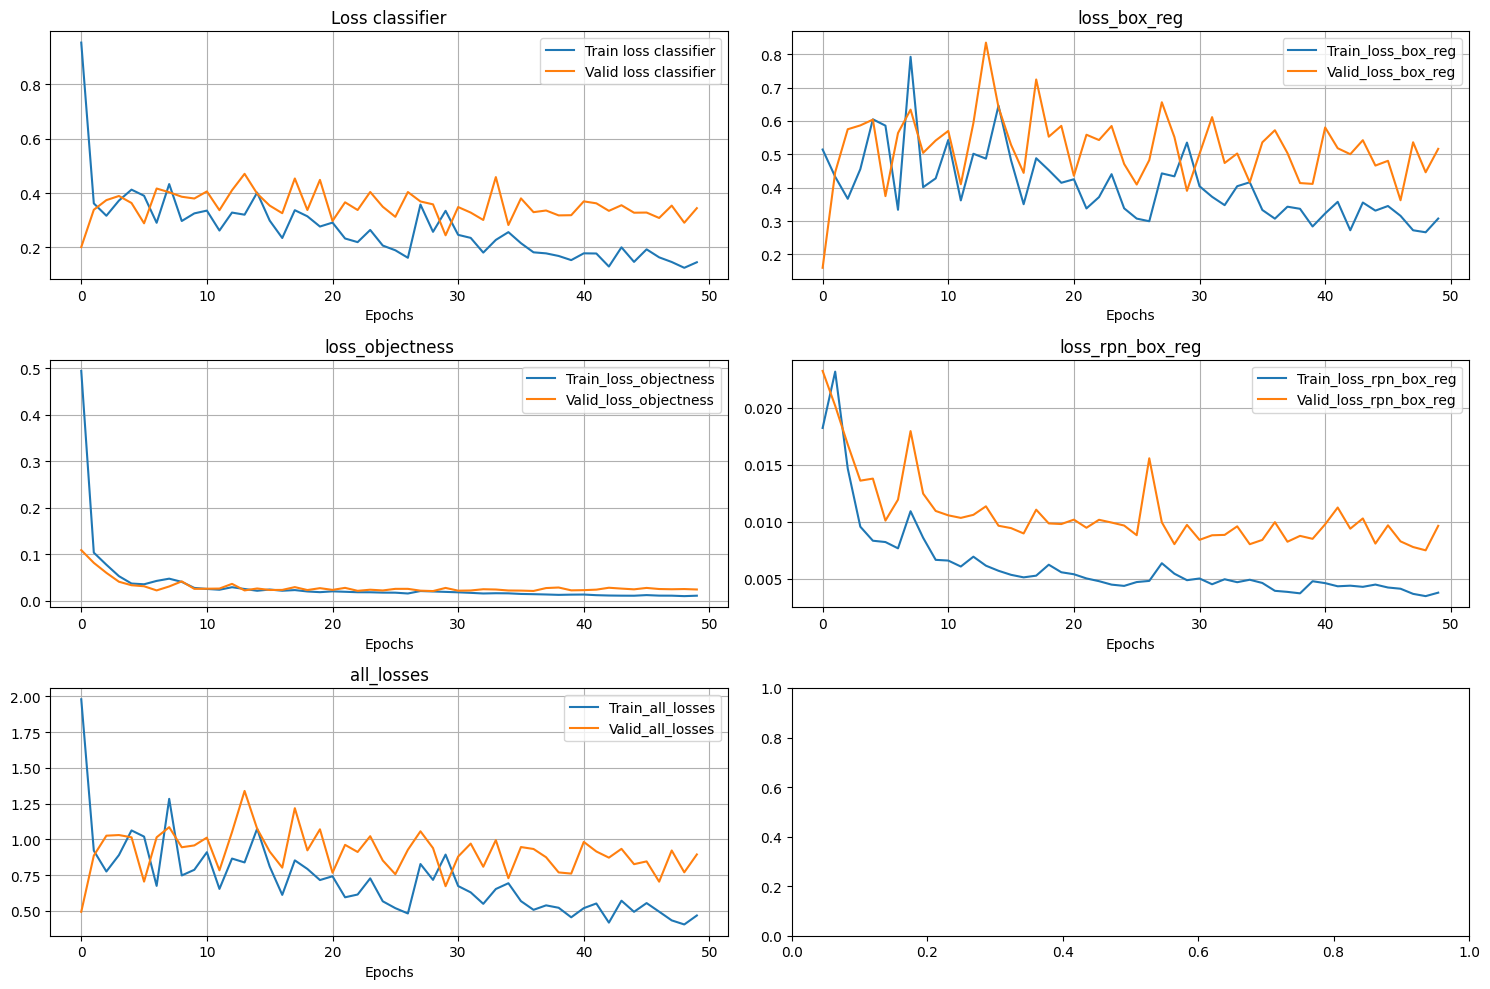

In [11]:
Train_loss_classifier =  [0.9531607372420174, 0.3619130573102406, 0.3165925826345171, 0.37236023374966215, 0.4125293791294098, 0.39005533712250845, 0.29066903463431765, 0.433007504258837, 0.29722496228558676, 0.32526599509375437, 0.335457763501576, 0.2621607652732304, 0.32824293630463736, 0.32044910533087595, 0.40161903841154917, 0.2987787595817021, 0.23473401367664337, 0.33697397794042316, 0.31451255083084106, 0.2769239544868469, 0.29139034024306704, 0.23292184940406255, 0.21956164496285574, 0.2643456097160067, 0.20700374032769883, 0.18960839084216527, 0.16205936244555882, 0.3576812041657312, 0.2574350024972643, 0.33471811030592236, 0.24634724855422974, 0.23518221293176925, 0.18111340488706315, 0.22772507795265742, 0.2563557858977999, 0.21568795612880162, 0.1821157591683524, 0.1782775010381426, 0.16871654774461473, 0.1534499419586999, 0.17840041858809336, 0.17778378086430685, 0.12981514632701874, 0.20052053885800497, 0.14694450902087347, 0.1930583736726216, 0.16368109839303152, 0.14654344958918436, 0.12522418051958084, 0.14563292690685817]
Valid_loss_classifier =  [0.20135998725891113, 0.33860746026039124, 0.3739994466304779, 0.3892468810081482, 0.36340513825416565, 0.288766473531723, 0.41668838262557983, 0.4029722809791565, 0.3864508867263794, 0.3799320161342621, 0.40594369173049927, 0.33705246448516846, 0.41030076146125793, 0.4706670045852661, 0.39797472953796387, 0.353892982006073, 0.32588595151901245, 0.4535945951938629, 0.337677001953125, 0.4484237730503082, 0.297468364238739, 0.3659789264202118, 0.3376764953136444, 0.40395113825798035, 0.3496672213077545, 0.31259283423423767, 0.4037351906299591, 0.3690702021121979, 0.35844436287879944, 0.2446581870317459, 0.34856411814689636, 0.3282143473625183, 0.3010183274745941, 0.4586838483810425, 0.282473087310791, 0.38039711117744446, 0.32975631952285767, 0.335870623588562, 0.31787875294685364, 0.31858888268470764, 0.36942392587661743, 0.36226487159729004, 0.33460578322410583, 0.35521093010902405, 0.32776379585266113, 0.3283379077911377, 0.3084205687046051, 0.35387223958969116, 0.2908749580383301, 0.3444618582725525]
Train_loss_box_reg =  [0.5143537031752723, 0.4327207122530256, 0.36670211809022085, 0.4555168833051409, 0.6048916407993862, 0.5858865252562931, 0.3337755139384951, 0.7921737219606128, 0.4014290528638022, 0.4279219721044813, 0.5429425580160958, 0.36189860105514526, 0.5016788627420153, 0.4870254695415497, 0.6457547119685582, 0.4818477928638458, 0.35047199044908794, 0.48823046684265137, 0.4525869446141379, 0.41471010020800997, 0.4252619871071407, 0.3378087282180786, 0.3717601214136396, 0.4404972621372768, 0.3381922287600381, 0.30741982587746214, 0.29946963276181904, 0.4428350584847586, 0.434009781905583, 0.5351315566471645, 0.4043250722544534, 0.37270812477384296, 0.347651869058609, 0.4044283287865775, 0.41622271282332285, 0.33322568024907795, 0.307192006281444, 0.3430543541908264, 0.33673617243766785, 0.2837558367422649, 0.32281208889825, 0.3576305423464094, 0.27240884729794096, 0.3555481306144169, 0.33124615039144245, 0.34511542320251465, 0.3156606980732509, 0.27238438384873526, 0.26640006474086214, 0.3075329746518816]
Valid_loss_box_reg =  [0.15997228026390076, 0.44628816843032837, 0.575141429901123, 0.5866238474845886, 0.6039465665817261, 0.37465423345565796, 0.5637463331222534, 0.6338499784469604, 0.5043769478797913, 0.5414479970932007, 0.5700151920318604, 0.41027820110321045, 0.5935357809066772, 0.8347623348236084, 0.640770673751831, 0.5282852649688721, 0.44439035654067993, 0.7243103384971619, 0.5527701377868652, 0.5852612257003784, 0.4357577860355377, 0.5586660504341125, 0.5427735447883606, 0.5848331451416016, 0.4710586965084076, 0.40947431325912476, 0.4826168417930603, 0.6559677124023438, 0.5518363118171692, 0.3905685544013977, 0.501358687877655, 0.6114386320114136, 0.47400587797164917, 0.5024402141571045, 0.4161042273044586, 0.535890519618988, 0.5721481442451477, 0.503750205039978, 0.41388726234436035, 0.4113353490829468, 0.5804700255393982, 0.5181840062141418, 0.5003383159637451, 0.5422808527946472, 0.4662921726703644, 0.4805438220500946, 0.3623289167881012, 0.5361068844795227, 0.44613826274871826, 0.5163720846176147]
Train_loss_rpn_box_reg =  [0.018225865638149635, 0.023169235193303654, 0.014664939471653529, 0.009565891564956732, 0.00833481237558382, 0.00821827950754336, 0.00766730062397463, 0.01092126446643046, 0.008593358032937561, 0.006656827937279429, 0.006594794669321605, 0.006071325058915785, 0.006934548195983682, 0.006144643295556307, 0.005697643384337425, 0.005342382538531508, 0.005121023061552218, 0.0052705312014690465, 0.006230612085866076, 0.005568281215216432, 0.005394539862338986, 0.005027109191619924, 0.004786283309970584, 0.004483079770579934, 0.004372486512043646, 0.004709082988223859, 0.004809573758393526, 0.006360907506729875, 0.005441246022071157, 0.004872757010161877, 0.005021947502557721, 0.004515256932271379, 0.004954242014459201, 0.004695862664708069, 0.004911818342017276, 0.004628621307866914, 0.003940194046923092, 0.003847158813316907, 0.0037186486713056055, 0.004781657730096153, 0.004614064037533743, 0.004338065195562584, 0.0043913136635507855, 0.0042897919192910194, 0.004487993594791208, 0.004230711808694261, 0.004123717147324767, 0.003673127752595714, 0.003474488654839141, 0.003778265556320548]
Valid_loss_rpn_box_reg =  [0.023229628801345825, 0.020167024806141853, 0.01678137667477131, 0.013604139909148216, 0.013783309608697891, 0.010100188665091991, 0.011938509531319141, 0.01795290596783161, 0.012468275614082813, 0.01094577182084322, 0.010562263429164886, 0.010338150896131992, 0.01060570403933525, 0.011352513916790485, 0.009649697691202164, 0.009440871886909008, 0.00897193606942892, 0.011057795956730843, 0.009851769544184208, 0.009797517210245132, 0.010184046812355518, 0.009472794830799103, 0.010171162895858288, 0.00992835033684969, 0.009667273610830307, 0.008819027803838253, 0.015568003989756107, 0.009946479462087154, 0.008033506572246552, 0.009724972769618034, 0.008411469869315624, 0.00881281029433012, 0.008846267126500607, 0.009597248397767544, 0.00803013239055872, 0.008405760861933231, 0.009962364099919796, 0.008247127756476402, 0.00876053236424923, 0.008501170203089714, 0.009775742888450623, 0.011248007416725159, 0.009390159510076046, 0.010289190337061882, 0.008083772845566273, 0.009684975259006023, 0.008278056047856808, 0.007781303022056818, 0.007492519449442625, 0.009639156982302666]
Train_loss_objectness =  [0.4940214327403477, 0.10307227181536811, 0.07711675976003919, 0.0525153103683676, 0.03664210891085012, 0.03502815482871873, 0.042283649423292706, 0.0470934451690742, 0.040226864495447705, 0.027202239792261804, 0.024999906441995075, 0.023275558171527728, 0.028708448899643763, 0.02489860142980303, 0.02107409281390054, 0.023738417774438858, 0.02113873272069863, 0.022543225969587053, 0.019567073988062993, 0.018053789223943437, 0.01981435716152191, 0.018892479528273855, 0.017906766650932177, 0.017826416130576814, 0.01710876529770238, 0.01695385029805558, 0.0152125692527209, 0.02045279661459582, 0.019556714487927302, 0.018655288299279555, 0.01774077463362898, 0.01657658096935068, 0.015221638205860342, 0.01577063343886818, 0.01553465159876006, 0.014234752926443304, 0.013725441747478076, 0.013077438010701112, 0.012249889650515147, 0.01273338230592864, 0.012948114291897841, 0.011579889804124832, 0.010846214635031564, 0.010522473736533098, 0.010403673696730818, 0.011751693141247545, 0.010612191765436105, 0.01052427850663662, 0.009534755588642188, 0.010468975574310337]
Valid_loss_objectness =  [0.10853762179613113, 0.08114363253116608, 0.05965369567275047, 0.040510937571525574, 0.03298317268490791, 0.030766654759645462, 0.0218502227216959, 0.03034023754298687, 0.04130815342068672, 0.025154080241918564, 0.02549978904426098, 0.02580106072127819, 0.03593422845005989, 0.021831044927239418, 0.025983966886997223, 0.022771548479795456, 0.022908391430974007, 0.028911899775266647, 0.022611528635025024, 0.026683259755373, 0.02296268753707409, 0.02730439230799675, 0.020959803834557533, 0.023343408480286598, 0.02174130268394947, 0.025188425555825233, 0.025200992822647095, 0.02128477208316326, 0.020441902801394463, 0.027192961424589157, 0.02127746492624283, 0.02168322540819645, 0.024361509829759598, 0.023756379261612892, 0.02167055942118168, 0.02142588421702385, 0.020667649805545807, 0.02689305506646633, 0.02808425761759281, 0.021971825510263443, 0.022379562258720398, 0.023465847596526146, 0.027571972459554672, 0.025735456496477127, 0.024148819968104362, 0.027190908789634705, 0.02483215369284153, 0.02433124929666519, 0.02477652207016945, 0.023824257776141167]
Train_all_losses =  [1.9797617197036743, 0.9208752768380302, 0.7750764063426426, 0.8899583050182888, 1.0623979313032967, 1.0191882763590132, 0.6743954845837185, 1.2831959298678808, 0.7474742446626935, 0.7870470285415649, 0.9099950194358826, 0.6534062623977661, 0.8655647805758885, 0.8385178446769714, 1.0741454788616724, 0.8097073606082371, 0.6114657350948879, 0.8530181986945016, 0.7928971733365741, 0.7152561289923531, 0.7418612326894488, 0.5946501663752964, 0.6140148171356746, 0.7271523560796466, 0.5666772212300982, 0.5186911565916879, 0.4815511235169002, 0.8273299251283918, 0.7164427382605416, 0.8933777127947126, 0.6734350664275033, 0.6289821778024945, 0.5489411524363926, 0.6526198898042951, 0.6930249673979623, 0.5677770205906459, 0.5069733943258014, 0.5382564493588039, 0.5214212664536068, 0.45472081218447, 0.5187746797289167, 0.5513322736535754, 0.4174615144729614, 0.5708809494972229, 0.49308231472969055, 0.55415620974132, 0.4940776952675411, 0.43312524471964153, 0.404633492231369, 0.46741314019475666]
Valid_all_losses =  [0.49309951066970825, 0.886206328868866, 1.025575876235962, 1.029985785484314, 1.0141181945800781, 0.7042875289916992, 1.014223337173462, 1.0851154327392578, 0.9446042776107788, 0.9574798941612244, 1.0120209455490112, 0.7834698557853699, 1.0503764152526855, 1.3386129140853882, 1.0743790864944458, 0.9143906831741333, 0.8021566271781921, 1.2178747653961182, 0.9229103922843933, 1.070165753364563, 0.7663729190826416, 0.9614221453666687, 0.9115809798240662, 1.0220561027526855, 0.8521345257759094, 0.7560746073722839, 0.9271210432052612, 1.0562691688537598, 0.9387561082839966, 0.6721446514129639, 0.8796117305755615, 0.9701489806175232, 0.8082319498062134, 0.9944776892662048, 0.7282779812812805, 0.9461193084716797, 0.9325345158576965, 0.8747610449790955, 0.7686107754707336, 0.76039719581604, 0.982049286365509, 0.9151627421379089, 0.8719062805175781, 0.9335164427757263, 0.8262885212898254, 0.8457576632499695, 0.7038596868515015, 0.9220917224884033, 0.7692822813987732, 0.8942973613739014]

# Crear una figura y una cuadrícula de subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Acceder a cada subplot individualmente y graficar
axs[0, 0].plot(Train_loss_classifier, label="Train loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].plot(Valid_loss_classifier, label="Valid loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].set_title('Loss classifier')
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(Train_loss_box_reg, label="Train_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].plot(Valid_loss_box_reg, label="Valid_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].set_title('loss_box_reg')
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(Train_loss_objectness, label="Train_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].plot(Valid_loss_objectness, label="Valid_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].set_title('loss_objectness')
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(Train_loss_rpn_box_reg, label="Train_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].plot(Valid_loss_rpn_box_reg, label="Valid_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].set_title('loss_rpn_box_reg')
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].grid()
axs[1, 1].legend()

axs[2, 0].plot(Train_all_losses, label="Train_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].plot(Valid_all_losses, label="Valid_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].set_title('all_losses')
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].grid()
axs[2, 0].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


- Para el modelo con optimizer = torch.optim.SGD(MovilNetV3.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-1)   
Mejor modelo--> Movilnet22.pt

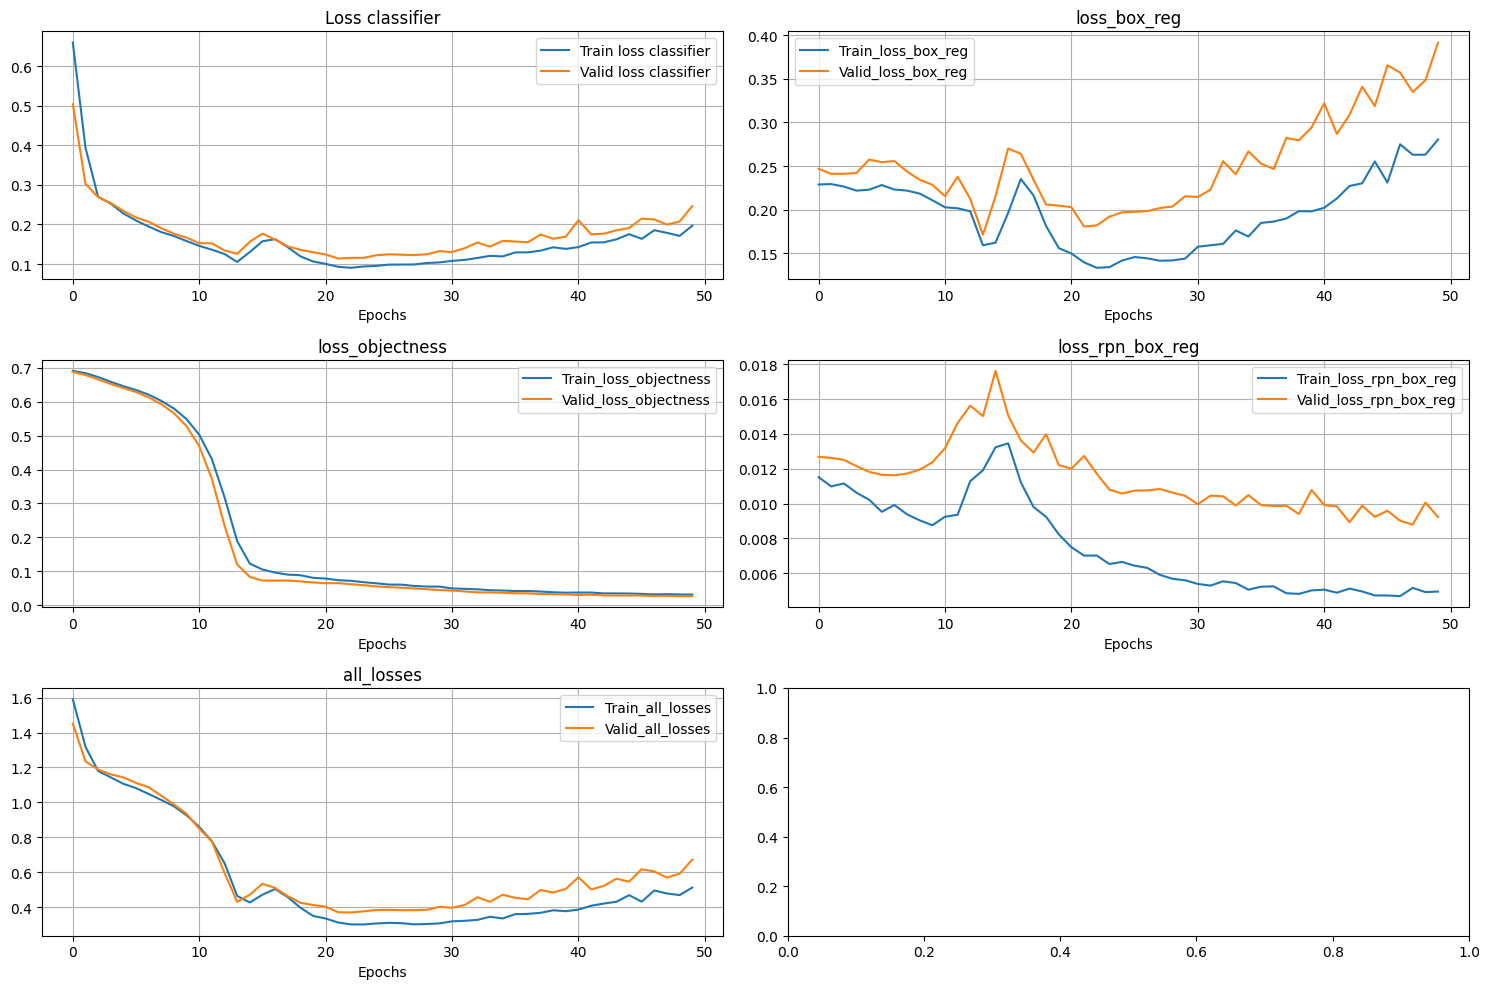

In [20]:
Train_loss_classifier =  [0.6592056410653251, 0.39395067521503996, 0.26978335210255217, 0.2523798772266933, 0.22771270360265458, 0.20977774475302016, 0.1945028454065323, 0.18052387876170023, 0.17069291642733983, 0.15796113439968654, 0.14580632746219635, 0.1361939162015915, 0.12525595085961477, 0.10530084158693041, 0.13025665815387452, 0.1573921548468726, 0.16277071833610535, 0.14238834381103516, 0.11943292830671583, 0.10641691088676453, 0.10036381014755794, 0.09291522204875946, 0.09042927942105702, 0.09376652645213264, 0.09515878771032606, 0.0984332806297711, 0.09861111853803907, 0.09877602330275945, 0.10252575895615987, 0.10400663422686714, 0.10790014266967773, 0.11041857621499471, 0.11519267622913633, 0.12062379717826843, 0.11920549401215144, 0.12926290184259415, 0.12944126980645315, 0.13377669666494643, 0.142253401024001, 0.13817607930728368, 0.14272031826632364, 0.1543634533882141, 0.15474453142711095, 0.1623086290700095, 0.17538227779524668, 0.16361342583383834, 0.18536962355886186, 0.17863760249955313, 0.17095741203853063, 0.1967210599354335]
Valid_loss_classifier =  [0.5037146806716919, 0.302315890789032, 0.26906996965408325, 0.25387752056121826, 0.23410053551197052, 0.2175043225288391, 0.20666609704494476, 0.19036850333213806, 0.17640511691570282, 0.16649048030376434, 0.1526876837015152, 0.15224379301071167, 0.1343553364276886, 0.12576837837696075, 0.15610702335834503, 0.1767536997795105, 0.16140630841255188, 0.14458930492401123, 0.13585960865020752, 0.12987712025642395, 0.12410031259059906, 0.11378920078277588, 0.1154169961810112, 0.11560999602079391, 0.12204337865114212, 0.12446386367082596, 0.1235070675611496, 0.12253192067146301, 0.12450084835290909, 0.1325587034225464, 0.13026201725006104, 0.13997501134872437, 0.15421196818351746, 0.14401334524154663, 0.15835635364055634, 0.15679746866226196, 0.15495891869068146, 0.17443197965621948, 0.16381491720676422, 0.16912755370140076, 0.2107059210538864, 0.17498518526554108, 0.17656837403774261, 0.18520057201385498, 0.19079743325710297, 0.21473847329616547, 0.21235793828964233, 0.19961394369602203, 0.2074376493692398, 0.2461804747581482]
Train_loss_box_reg =  [0.2288221631731306, 0.2292983361652919, 0.22644844225474767, 0.2217744823013033, 0.2228685681309019, 0.22819170568670546, 0.22303414983408792, 0.22181367661271775, 0.2184076394353594, 0.21081401407718658, 0.20269945050988877, 0.20156502510820115, 0.19812278662409102, 0.15914001635142735, 0.1621671106134142, 0.19641191831656865, 0.23510797960417612, 0.2163328230381012, 0.18118890268462046, 0.155967150415693, 0.14968243454183852, 0.13964827358722687, 0.13337041756936482, 0.13409272581338882, 0.14164109102317265, 0.14571677574089595, 0.14420160864080703, 0.1414247133902141, 0.1418615984065192, 0.14392087927886418, 0.1575078602348055, 0.15917591750621796, 0.16079369825976236, 0.17618959503514425, 0.16921719908714294, 0.18479751901967184, 0.1863219141960144, 0.18988336622714996, 0.1982916976724352, 0.19803581706115178, 0.20216222533157893, 0.2128626619066511, 0.22711939896856034, 0.23018078931740352, 0.2552227995225361, 0.23105073826653616, 0.2749312860625131, 0.2629402471440179, 0.2629565937178476, 0.2803133853844234]
Valid_loss_box_reg =  [0.24682031571865082, 0.24103164672851562, 0.24111846089363098, 0.24197950959205627, 0.25736531615257263, 0.2543845474720001, 0.25575491786003113, 0.24349883198738098, 0.23432153463363647, 0.22848527133464813, 0.21538737416267395, 0.23770566284656525, 0.21217262744903564, 0.17117251455783844, 0.21550731360912323, 0.2701388895511627, 0.263893187046051, 0.2344367504119873, 0.20586277544498444, 0.2046266347169876, 0.20283707976341248, 0.1806669384241104, 0.1819385141134262, 0.19187882542610168, 0.19690468907356262, 0.1975371092557907, 0.19822223484516144, 0.20179754495620728, 0.20366623997688293, 0.21541239321231842, 0.21447201073169708, 0.22282981872558594, 0.2555522620677948, 0.24051521718502045, 0.2667101323604584, 0.25278958678245544, 0.24656857550144196, 0.28211453557014465, 0.2794252038002014, 0.29429709911346436, 0.3219672441482544, 0.28683632612228394, 0.3086307644844055, 0.34081998467445374, 0.3186204433441162, 0.36544835567474365, 0.35706302523612976, 0.3348328769207001, 0.34823620319366455, 0.3914183974266052]
Train_loss_rpn_box_reg =  [0.011517804515148913, 0.010987979359924793, 0.011158207830573832, 0.010625173869941915, 0.010223506284611565, 0.00952946674078703, 0.009918624934341227, 0.009381063681628023, 0.009038255683013372, 0.008757011166640691, 0.009245732266988074, 0.009357878539179052, 0.011290106124111585, 0.011909526506704944, 0.013234765268862247, 0.013460851141384669, 0.011222579915608679, 0.009804699569940567, 0.009238471144012042, 0.008234966014112746, 0.0074958572430270055, 0.007010977981345994, 0.007019786230687585, 0.00652759216193642, 0.00665090572355049, 0.006433566500033651, 0.006307392248085567, 0.005906543295298304, 0.005680121547941651, 0.005594647955149412, 0.005386940137084041, 0.00528974731319717, 0.005536450272692102, 0.0054364024794527465, 0.005055095601294722, 0.005228009474064622, 0.005244741615440164, 0.004851876691515956, 0.004814249596425465, 0.005014491134456226, 0.005057453443961484, 0.004882743382560355, 0.005118721164762974, 0.004951913508453539, 0.004728008859923908, 0.004722330353355834, 0.00468557424444173, 0.005159448499658278, 0.004916661618543523, 0.0049489702630255905]
Valid_loss_rpn_box_reg =  [0.012687214650213718, 0.01262433361262083, 0.012511136010289192, 0.012150168418884277, 0.011821433901786804, 0.011654178611934185, 0.011624985374510288, 0.01172481570392847, 0.01195055153220892, 0.012366422452032566, 0.013185792602598667, 0.014630300924181938, 0.01562465913593769, 0.015025338158011436, 0.01761944219470024, 0.015061885118484497, 0.013626056723296642, 0.012932625599205494, 0.013983489014208317, 0.01221570186316967, 0.01200095098465681, 0.012735465541481972, 0.011725210584700108, 0.010804292745888233, 0.010578473098576069, 0.010744689032435417, 0.010757222771644592, 0.010838044807314873, 0.010630721226334572, 0.01044395286589861, 0.009962663985788822, 0.010455893352627754, 0.010416228324174881, 0.009892470203340054, 0.010488750413060188, 0.009914124384522438, 0.009858755394816399, 0.009874269366264343, 0.009402521885931492, 0.010782595723867416, 0.009915897622704506, 0.009838179685175419, 0.008930951356887817, 0.009877257980406284, 0.009237011894583702, 0.009592938236892223, 0.009014338254928589, 0.008793647401034832, 0.010063073597848415, 0.009226997382938862]
Train_loss_objectness =  [0.6908812182290214, 0.684366490159716, 0.6728097796440125, 0.6586731246539524, 0.6458902103560311, 0.634602963924408, 0.6208881735801697, 0.6024702446801322, 0.5797899450574603, 0.54856789963586, 0.5025657372815269, 0.4307124742439815, 0.3184435410158975, 0.18876009540898459, 0.1223002193229539, 0.10485619945185524, 0.0959056509392602, 0.08979569162641253, 0.0881475220833506, 0.08037937326090676, 0.07823177107742854, 0.07330044358968735, 0.07169513936553683, 0.06752499884792737, 0.06427348884088653, 0.06057955803615706, 0.06026150073323931, 0.056403231407914846, 0.054636756756475995, 0.054471462432827265, 0.0490506078515734, 0.04791355452367237, 0.046505884400435855, 0.04385547286697796, 0.042940088148627965, 0.04145830922893116, 0.04154250664370401, 0.040028346968548636, 0.03774105065635273, 0.036472130832927566, 0.037032434450728555, 0.03693783442888941, 0.03454859208847795, 0.034365901191319735, 0.03408401778766087, 0.03304633338536535, 0.031408194984708517, 0.03232188469597271, 0.031228612044027874, 0.031014481293303624]
Valid_loss_objectness =  [0.6881008744239807, 0.6789935827255249, 0.665688157081604, 0.6525141596794128, 0.6404155492782593, 0.6284677982330322, 0.612899899482727, 0.5927847027778625, 0.5661887526512146, 0.5274783968925476, 0.4690150320529938, 0.3720256984233856, 0.2342924177646637, 0.11964918673038483, 0.08309397101402283, 0.07226796448230743, 0.07215246558189392, 0.07245000451803207, 0.06991829723119736, 0.0667194202542305, 0.06442858278751373, 0.06463385373353958, 0.06159212812781334, 0.05849675461649895, 0.05509055405855179, 0.05287604406476021, 0.05119528993964195, 0.049056317657232285, 0.046821948140859604, 0.0444214753806591, 0.04279918968677521, 0.040203921496868134, 0.03747154027223587, 0.037365615367889404, 0.036296211183071136, 0.03494953364133835, 0.034603897482156754, 0.03264423832297325, 0.03214247152209282, 0.03141527250409126, 0.02972015179693699, 0.03077436052262783, 0.02834307588636875, 0.028080204501748085, 0.028195474296808243, 0.028082970529794693, 0.026581158861517906, 0.027202406898140907, 0.026388665661215782, 0.026577690616250038]
Train_all_losses =  [1.5904268026351929, 1.3186034985951014, 1.1801998104367937, 1.1434526613780431, 1.106694987842015, 1.0821018729891096, 1.0483437776565552, 1.014188860143934, 0.97792877469744, 0.9261000582150051, 0.8603172472545079, 0.7778292979512896, 0.6531123859541756, 0.4651104807853699, 0.42795874391283306, 0.4721211152417319, 0.5050069264003209, 0.458321567092623, 0.39800781437328886, 0.35099839312689646, 0.33577386822019306, 0.3128749132156372, 0.3025146211896624, 0.30191183941704886, 0.307724267244339, 0.31116317425455364, 0.30938162548201426, 0.3025105084691729, 0.30470424039023264, 0.30799362489155363, 0.31984554869788034, 0.32279779655592783, 0.32802870869636536, 0.34610527753829956, 0.3364178878920419, 0.3607467370373862, 0.3625504289354597, 0.3685402955327715, 0.38310040320668903, 0.37769852365766254, 0.38697242736816406, 0.4090466967650822, 0.4215312472411564, 0.4318072327545711, 0.4694170909268515, 0.43243283459118437, 0.4963946725640978, 0.47905918104307993, 0.47005927562713623, 0.5129979082516262]
Valid_all_losses =  [1.4513230323791504, 1.234965443611145, 1.1883877515792847, 1.160521388053894, 1.1437028646469116, 1.1120108366012573, 1.08694589138031, 1.0383769273757935, 0.9888659715652466, 0.9348205327987671, 0.8502759337425232, 0.776605486869812, 0.5964450240135193, 0.4316154420375824, 0.47232773900032043, 0.5342224836349487, 0.5110780000686646, 0.4644086956977844, 0.42562416195869446, 0.4134388864040375, 0.40336689352989197, 0.3718254268169403, 0.3706728518009186, 0.3767898678779602, 0.3846170902252197, 0.38562172651290894, 0.3836818337440491, 0.3842238187789917, 0.38561975955963135, 0.40283650159835815, 0.3974958658218384, 0.41346466541290283, 0.4576520025730133, 0.4317866563796997, 0.4718514382839203, 0.45445072650909424, 0.4459901452064514, 0.4990650415420532, 0.4847850799560547, 0.5056225061416626, 0.5723091959953308, 0.5024340152740479, 0.5224732160568237, 0.5639780163764954, 0.5468503832817078, 0.6178627610206604, 0.6050164699554443, 0.5704429149627686, 0.5921255350112915, 0.6734035611152649]

# Crear una figura y una cuadrícula de subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Acceder a cada subplot individualmente y graficar

axs[0, 0].plot(Train_loss_classifier, label="Train loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].plot(Valid_loss_classifier, label="Valid loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].set_title('Loss classifier')
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(Train_loss_box_reg, label="Train_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].plot(Valid_loss_box_reg, label="Valid_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].set_title('loss_box_reg')
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(Train_loss_objectness, label="Train_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].plot(Valid_loss_objectness, label="Valid_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].set_title('loss_objectness')
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(Train_loss_rpn_box_reg, label="Train_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].plot(Valid_loss_rpn_box_reg, label="Valid_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].set_title('loss_rpn_box_reg')
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].grid()
axs[1, 1].legend()

axs[2, 0].plot(Train_all_losses, label="Train_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].plot(Valid_all_losses, label="Valid_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].set_title('all_losses')
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].grid()
axs[2, 0].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


- Modelo con optimizer = torch.optim.SGD(MovilNetV3.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)   
Mejor modelo --> Movilnet25.pt

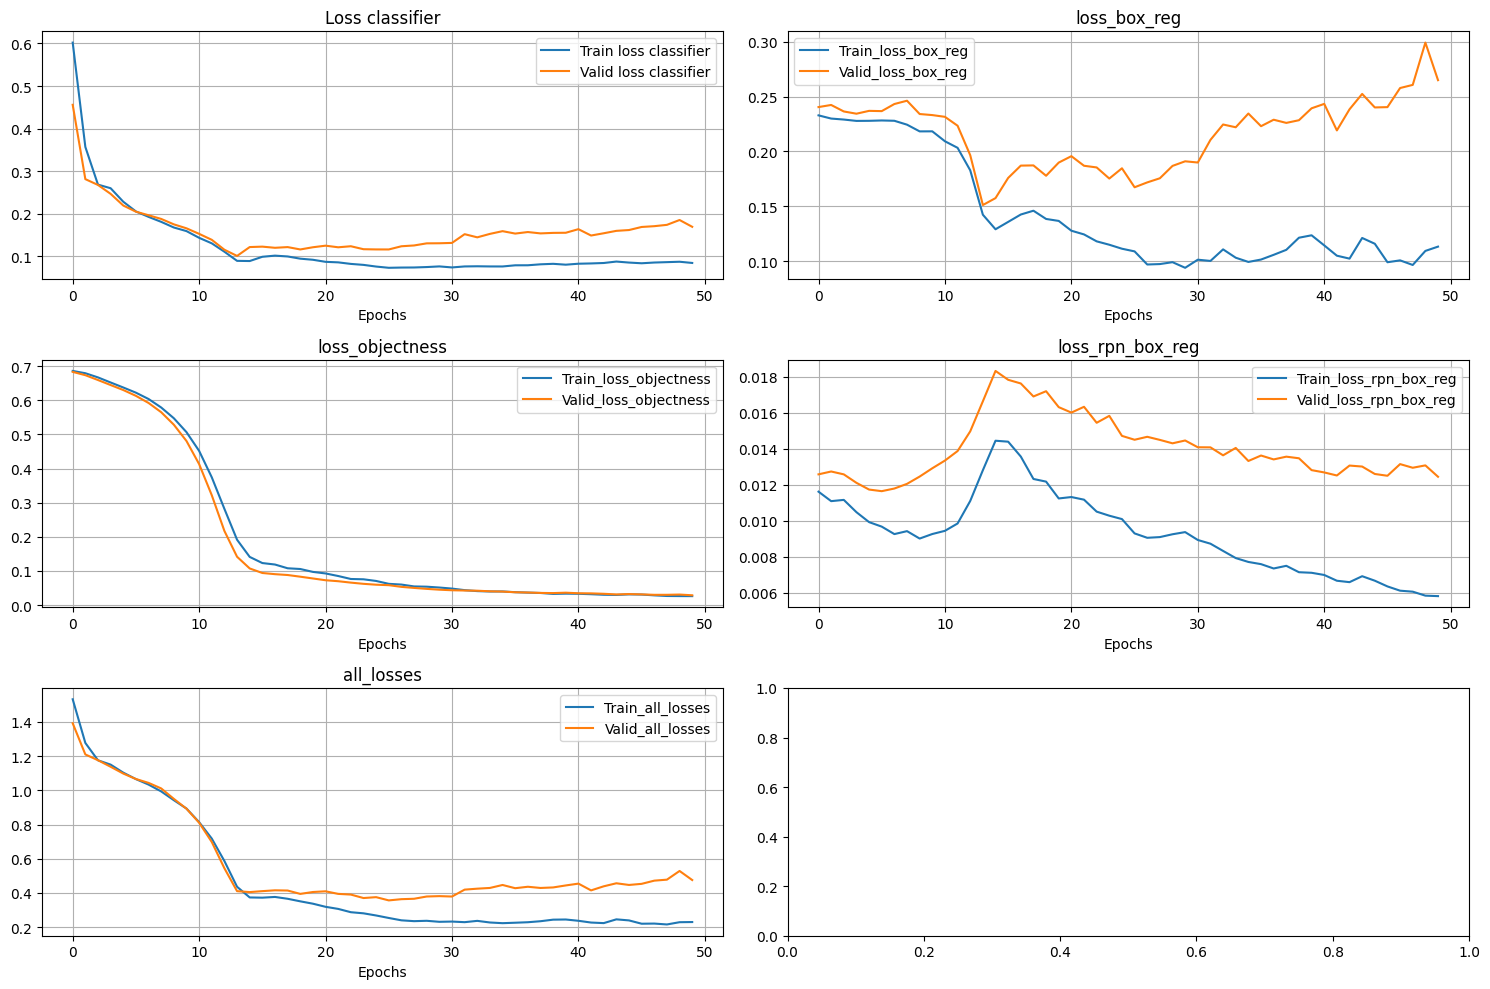

In [19]:
Train_loss_classifier =  [0.6020776586873191, 0.3569305326257433, 0.2683889312403543, 0.25992789438792635, 0.2282015255519322, 0.20539078755038126, 0.1926319577864238, 0.18092643576008932, 0.16765884842191422, 0.1591984714780535, 0.14342040036405837, 0.13042931684425899, 0.11075352451631001, 0.0892956576177052, 0.08886399226529258, 0.09886772079127175, 0.10154929969991956, 0.09961977920361928, 0.09442557500941413, 0.09184652354036059, 0.087003692984581, 0.08576747349330358, 0.08212504642350334, 0.07983744889497757, 0.07589989900588989, 0.0729925547327314, 0.07355401771409172, 0.0737266018986702, 0.07473936464105334, 0.07625336306435722, 0.07385537773370743, 0.07617563435009547, 0.07655752450227737, 0.07617262750864029, 0.07611302392823356, 0.07884651635374341, 0.07891135237046651, 0.08116700180939265, 0.08233152436358589, 0.08031134946005684, 0.08256105865750994, 0.08322741516998836, 0.08425028302839824, 0.08764162021023887, 0.08527640253305435, 0.0836275230560984, 0.08536020879234586, 0.08627687288182122, 0.08720652759075165, 0.0843673146196774]
Valid_loss_classifier =  [0.45595061779022217, 0.28130823373794556, 0.26761841773986816, 0.24667763710021973, 0.21930056810379028, 0.20480181276798248, 0.19641847908496857, 0.18779364228248596, 0.1750493347644806, 0.16573874652385712, 0.1527399867773056, 0.13872165977954865, 0.11538654565811157, 0.1008787676692009, 0.12170004844665527, 0.1226959377527237, 0.11998707801103592, 0.12162923067808151, 0.11609659343957901, 0.12125701457262039, 0.12495514750480652, 0.12117592245340347, 0.12363528460264206, 0.11665559560060501, 0.11614929884672165, 0.11607798933982849, 0.12357669323682785, 0.12546858191490173, 0.13042332231998444, 0.1306273490190506, 0.13144783675670624, 0.15198996663093567, 0.1445499211549759, 0.15265639126300812, 0.15906481444835663, 0.15338897705078125, 0.15698984265327454, 0.15381257236003876, 0.1550145447254181, 0.15529349446296692, 0.1637454777956009, 0.14880366623401642, 0.15411590039730072, 0.15978273749351501, 0.161688432097435, 0.16891314089298248, 0.17076201736927032, 0.17388883233070374, 0.18528154492378235, 0.1692865639925003]
Train_loss_box_reg =  [0.2328590133360454, 0.22993973536150797, 0.22904678753444127, 0.2278080199445997, 0.22788588915552413, 0.2282040183033262, 0.2279217392206192, 0.2243769552026476, 0.21826312158788955, 0.21830761432647705, 0.20926338008471898, 0.20328885316848755, 0.1828047548021589, 0.1423599592276982, 0.12911111222846167, 0.13581934784139907, 0.14254965313843318, 0.14601042653833116, 0.13851151296070643, 0.13670744746923447, 0.12779069585459574, 0.12441552323954445, 0.11810779465096337, 0.11501568449395043, 0.1113947896020753, 0.1089607977441379, 0.09702341364962715, 0.09741369954177312, 0.0991327241063118, 0.09402005800179072, 0.1013993386711393, 0.10026169674737113, 0.11080017153705869, 0.10320049098559789, 0.09935396909713745, 0.10153375778879438, 0.10583171993494034, 0.11038094226803098, 0.12141583008425576, 0.1236244450722422, 0.11442325583526067, 0.10504675230809621, 0.10237108170986176, 0.12118787318468094, 0.11591764220169612, 0.09908594403948102, 0.10078388026782445, 0.09659128103937421, 0.10939724424055644, 0.11330183914729527]
Valid_loss_box_reg =  [0.2404060810804367, 0.24232687056064606, 0.23641258478164673, 0.23436683416366577, 0.23695658147335052, 0.23671743273735046, 0.24318759143352509, 0.24619324505329132, 0.23407943546772003, 0.23310688138008118, 0.23151585459709167, 0.22342516481876373, 0.19658786058425903, 0.1511797457933426, 0.15749162435531616, 0.17585770785808563, 0.18708980083465576, 0.18727508187294006, 0.1778566539287567, 0.18984563648700714, 0.19569961726665497, 0.18695513904094696, 0.18542411923408508, 0.17529965937137604, 0.18465043604373932, 0.16737022995948792, 0.17179393768310547, 0.17556431889533997, 0.1868293136358261, 0.19101564586162567, 0.1899070143699646, 0.21052633225917816, 0.22453904151916504, 0.22200711071491241, 0.2345229983329773, 0.2229955941438675, 0.2288849800825119, 0.22599531710147858, 0.22843103110790253, 0.23929180204868317, 0.2433042824268341, 0.21914686262607574, 0.2383832186460495, 0.2523905634880066, 0.2400738149881363, 0.24036052823066711, 0.25774940848350525, 0.2606126368045807, 0.2991359531879425, 0.26490214467048645]
Train_loss_rpn_box_reg =  [0.011612799018621445, 0.011085891430931432, 0.011155647624816214, 0.010471830410616738, 0.009918177766459329, 0.00966790531362806, 0.009252057942960943, 0.009416503432605947, 0.009003195246415479, 0.00925585241722209, 0.009433194728834289, 0.009842612115400178, 0.011095853123281683, 0.012807166736040796, 0.014448321291378565, 0.014395130798220634, 0.013567893632820674, 0.01231964211910963, 0.012172064876982145, 0.011235616569008147, 0.011313887978238719, 0.011167949863842555, 0.010502047570688384, 0.010275884265346187, 0.010087785311043262, 0.009289996232837439, 0.009045719834310668, 0.009085366103265966, 0.009242863793458258, 0.009362661146691867, 0.008924295327493123, 0.008717769091682774, 0.008314938084887607, 0.007917808102709907, 0.007701525331607887, 0.007579879436109748, 0.007338342988597495, 0.00748663568603141, 0.007130328366266829, 0.007098641978310687, 0.006976711031581674, 0.006656062589692218, 0.006577239904020514, 0.006908065639436245, 0.006658279736127172, 0.006339789634304387, 0.0061027552001178265, 0.0060475376168532035, 0.005825963603066546, 0.005799575642283473]
Valid_loss_rpn_box_reg =  [0.012577502988278866, 0.012735768221318722, 0.01257600262761116, 0.012105157598853111, 0.011730401776731014, 0.01164071261882782, 0.01178845576941967, 0.012047871947288513, 0.01245350856333971, 0.012914998456835747, 0.013344460166990757, 0.013874029740691185, 0.014969664625823498, 0.016643013805150986, 0.018332775682210922, 0.017839163541793823, 0.017634740099310875, 0.016911208629608154, 0.01720401830971241, 0.016317177563905716, 0.01601424627006054, 0.01633591018617153, 0.015447200275957584, 0.015832722187042236, 0.014718206599354744, 0.014502339996397495, 0.014667057432234287, 0.014494435861706734, 0.014304167591035366, 0.01446117926388979, 0.01408449187874794, 0.014079100452363491, 0.013636160641908646, 0.014047292061150074, 0.013321139849722385, 0.013624446466565132, 0.013407934457063675, 0.013561297208070755, 0.013471532613039017, 0.012811858206987381, 0.012683333829045296, 0.012513496913015842, 0.013065976090729237, 0.013010925613343716, 0.012597760185599327, 0.012498103082180023, 0.013146908022463322, 0.012944068759679794, 0.01307615265250206, 0.012442564591765404]
Train_loss_objectness =  [0.6859006030218942, 0.6791647928101676, 0.6668952277728489, 0.6520067197935921, 0.6373532840183803, 0.6221718277250018, 0.6036595702171326, 0.5787429213523865, 0.5472903166498456, 0.5065337078911918, 0.4516362931047167, 0.3742872604301998, 0.2817476434367044, 0.19138778959001815, 0.14107574628932135, 0.123081593641213, 0.11875801001276289, 0.10779160154717309, 0.10564188020569938, 0.09715365618467331, 0.09262015457664217, 0.08509175372975213, 0.07641894476754325, 0.07550635508128575, 0.07062758186033793, 0.062193139855350764, 0.060058189289910455, 0.054594247468880246, 0.05383881500789097, 0.05135763968740191, 0.048274132290056775, 0.0437381522996085, 0.040883924812078476, 0.03976104435111795, 0.039868698588439395, 0.0377153397670814, 0.03648214867072446, 0.035411963505404334, 0.032692462471979, 0.03346439344542367, 0.03302509018353054, 0.031786520566259115, 0.0301905484603984, 0.029659895758543695, 0.03133761244160788, 0.030784632212349346, 0.028466508058565005, 0.026588973456195424, 0.026301506108471324, 0.026188980521900312]
Valid_loss_objectness =  [0.6831263899803162, 0.6733970642089844, 0.6592370271682739, 0.6445476412773132, 0.6299402713775635, 0.6129213571548462, 0.5920366048812866, 0.5649367570877075, 0.5283350348472595, 0.48059898614883423, 0.4129450023174286, 0.321776807308197, 0.21707352995872498, 0.1415310502052307, 0.10727041214704514, 0.09396155923604965, 0.09050291031599045, 0.08806101232767105, 0.0831245630979538, 0.07791104167699814, 0.07271990925073624, 0.06987757980823517, 0.06576205790042877, 0.062229812145233154, 0.05965641885995865, 0.05826687440276146, 0.053329553455114365, 0.050225503742694855, 0.04743674397468567, 0.045069362968206406, 0.0433836504817009, 0.04261770471930504, 0.04205602407455444, 0.04033982753753662, 0.039509113878011703, 0.0375073067843914, 0.03671916201710701, 0.03558702766895294, 0.03510401397943497, 0.036271244287490845, 0.03459307178854942, 0.03427474573254585, 0.033033277839422226, 0.031184937804937363, 0.03218814730644226, 0.031276896595954895, 0.03004172444343567, 0.030067497864365578, 0.03080892562866211, 0.028662871569395065]
Train_all_losses =  [1.5324500969478063, 1.277120930807931, 1.175486615725926, 1.150214501789638, 1.1033588647842407, 1.065434558050973, 1.0334653173174178, 0.9934628180095127, 0.9422154767172677, 0.8932956457138062, 0.8137532898357936, 0.717848036970411, 0.586401777608054, 0.4358505734375545, 0.37349916781697956, 0.37216379387038095, 0.37642485754830496, 0.3657414530004774, 0.3507510381085532, 0.3369432432310922, 0.3187284384455, 0.30644269926207407, 0.2871538315500532, 0.2806353781904493, 0.2680100543158395, 0.25343649089336395, 0.2396813460758754, 0.23481991248471396, 0.2369537651538849, 0.23099372855254582, 0.23245314615113394, 0.22889325874192373, 0.23655655767236436, 0.22705196695668356, 0.22303721521581923, 0.2256754913500377, 0.22856356416429793, 0.23444653834615434, 0.24357015107359206, 0.24449883188520158, 0.23698611983231135, 0.22671674617699214, 0.22338914445468358, 0.2453974485397339, 0.23918993983949935, 0.21983788907527924, 0.22071335358279093, 0.21550466758864267, 0.22873123841626303, 0.22965770959854126]
Valid_all_losses =  [1.39206063747406, 1.2097679376602173, 1.1758440732955933, 1.1376972198486328, 1.0979278087615967, 1.0660812854766846, 1.0434311628341675, 1.0109715461730957, 0.9499173164367676, 0.8923596143722534, 0.8105452656745911, 0.6977976560592651, 0.5440176129341125, 0.4102325737476349, 0.4047948718070984, 0.4103543758392334, 0.41521453857421875, 0.4138765335083008, 0.3942818343639374, 0.4053308963775635, 0.4093888998031616, 0.3943445682525635, 0.3902686834335327, 0.37001779675483704, 0.375174343585968, 0.3562174439430237, 0.3633672595024109, 0.36575284600257874, 0.37899354100227356, 0.3811735510826111, 0.37882301211357117, 0.41921308636665344, 0.4247811436653137, 0.42905062437057495, 0.44641807675361633, 0.42751631140708923, 0.4360019266605377, 0.42895621061325073, 0.4320211112499237, 0.4436684250831604, 0.45432618260383606, 0.4147387742996216, 0.4385983645915985, 0.45636916160583496, 0.4465481638908386, 0.4530486762523651, 0.4717000722885132, 0.47751304507255554, 0.5283025503158569, 0.4752941429615021]

# Crear una figura y una cuadrícula de subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Acceder a cada subplot individualmente y graficar
axs[0, 0].plot(Train_loss_classifier, label="Train loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].plot(Valid_loss_classifier, label="Valid loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].set_title('Loss classifier')
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(Train_loss_box_reg, label="Train_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].plot(Valid_loss_box_reg, label="Valid_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].set_title('loss_box_reg')
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(Train_loss_objectness, label="Train_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].plot(Valid_loss_objectness, label="Valid_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].set_title('loss_objectness')
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(Train_loss_rpn_box_reg, label="Train_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].plot(Valid_loss_rpn_box_reg, label="Valid_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].set_title('loss_rpn_box_reg')
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].grid()
axs[1, 1].legend()

axs[2, 0].plot(Train_all_losses, label="Train_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].plot(Valid_all_losses, label="Valid_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].set_title('all_losses')
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].grid()
axs[2, 0].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

- Modelo con optimizer = torch.optim.SGD(MovilNetV3.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-3)  
Mejor modelo --> MovilNetV3.pt

In [25]:
Train_loss_classifier =  [0.7022676808493478, 0.6435030783925738, 0.5700888889176505, 0.4957223321710314, 0.4380145115511758, 0.3863620672907148, 0.3479875198432377, 0.3214789458683559, 0.30197972484997343, 0.2883661261626652, 0.28068050742149353, 0.27223842058862957, 0.2681088319846562, 0.26392796635627747, 0.26262881074632916, 0.25842584456716267, 0.2549425108092172, 0.25207194685935974, 0.24752781646592276, 0.24363975865500315, 0.24325247960431234, 0.23942698538303375, 0.23725316992827825, 0.2325313240289688, 0.23193257408482687, 0.22788016072341374, 0.22534407249518804, 0.22394126653671265, 0.21952798536845616, 0.21783751675060817, 0.21546450895922525, 0.21308631556374685, 0.2106802271945136, 0.2070648627621787, 0.20703312754631042, 0.20358493072646006, 0.2000971862248012, 0.19709803376879012, 0.194827567253794, 0.19361362712723867, 0.19001260186944688, 0.18729065784386226, 0.18710232632500784, 0.18213542657239096, 0.18182497365134104, 0.17830371218068258, 0.17498062125274114, 0.17200306057929993, 0.17040395736694336, 0.16771418494837625]
Valid_loss_classifier =  [0.6796741485595703, 0.6094415783882141, 0.5370031595230103, 0.47174307703971863, 0.41689038276672363, 0.37341830134391785, 0.343295693397522, 0.31651678681373596, 0.2978585958480835, 0.2859457731246948, 0.27912279963493347, 0.27335479855537415, 0.2675664722919464, 0.26533812284469604, 0.26214781403541565, 0.25820428133010864, 0.25312572717666626, 0.2501571774482727, 0.24693070352077484, 0.24685800075531006, 0.24449890851974487, 0.2414231300354004, 0.23928816616535187, 0.23664450645446777, 0.23480676114559174, 0.23248685896396637, 0.22891664505004883, 0.22547554969787598, 0.22331640124320984, 0.2213788479566574, 0.21791505813598633, 0.21713078022003174, 0.21729439496994019, 0.21602781116962433, 0.2139284312725067, 0.2103167027235031, 0.20642799139022827, 0.20364166796207428, 0.20202749967575073, 0.20193861424922943, 0.19984731078147888, 0.19656653702259064, 0.19557547569274902, 0.19187988340854645, 0.18993163108825684, 0.1875852793455124, 0.18547500669956207, 0.18445515632629395, 0.18349912762641907, 0.17789888381958008]
Train_loss_box_reg =  [0.2302297673055104, 0.23275675731045858, 0.23092585802078247, 0.22960454438413894, 0.23129220732620784, 0.22725359669753484, 0.228681675025395, 0.22977842816284724, 0.2249916706766401, 0.22691422062260763, 0.22820161283016205, 0.2247385552951268, 0.22439653745719365, 0.2265321889093944, 0.2277046548468726, 0.2275888259921755, 0.22734418298516954, 0.22650296773229325, 0.22442523283617838, 0.22341622837952205, 0.22626626278672898, 0.2236630299261638, 0.2234545030764171, 0.22181401082447597, 0.22335287928581238, 0.22121040097304753, 0.22203174659184047, 0.22138622190271104, 0.219101967556136, 0.22056451865604945, 0.21841529224600112, 0.2205221951007843, 0.21819079773766653, 0.21714270114898682, 0.2203833907842636, 0.2184900449854987, 0.21690303087234497, 0.21532125983919417, 0.21569072348730906, 0.21590206027030945, 0.21372507299695695, 0.2107315787247249, 0.2137396995510374, 0.21086498669215611, 0.21222821090902602, 0.20939226235662187, 0.20917063738618577, 0.20857525510447367, 0.20939355024269649, 0.20852132780211313]
Valid_loss_box_reg =  [0.23831525444984436, 0.23975102603435516, 0.24210134148597717, 0.24022018909454346, 0.2457980215549469, 0.24332411587238312, 0.24494148790836334, 0.23293454945087433, 0.2280106246471405, 0.22947686910629272, 0.230524942278862, 0.23120753467082977, 0.2313259243965149, 0.23415516316890717, 0.23408254981040955, 0.23431535065174103, 0.22971203923225403, 0.23023328185081482, 0.22996675968170166, 0.2340509593486786, 0.23562709987163544, 0.23689401149749756, 0.23743808269500732, 0.2358950674533844, 0.23696227371692657, 0.23562057316303253, 0.23428964614868164, 0.230464905500412, 0.23055242002010345, 0.23028090596199036, 0.2274104654788971, 0.23190023005008698, 0.23474641144275665, 0.23590734601020813, 0.2368955761194229, 0.23327088356018066, 0.2317664474248886, 0.2291296273469925, 0.22992154955863953, 0.23314332962036133, 0.2329743355512619, 0.23139555752277374, 0.2343895584344864, 0.23143213987350464, 0.2305414378643036, 0.23062224686145782, 0.23026049137115479, 0.23250757157802582, 0.23383060097694397, 0.22740541398525238]
Train_loss_rpn_box_reg =  [0.011284602539879935, 0.011090392645980631, 0.01098165022475379, 0.010817574869309152, 0.011447786087436336, 0.011199971660971642, 0.010819070107702698, 0.011548720034105437, 0.01134556531906128, 0.011182184996349471, 0.011364390807492393, 0.011484437489083834, 0.011553042967404639, 0.01101879682391882, 0.011258236531700407, 0.010770635147179877, 0.01090853355292763, 0.01067488214799336, 0.011102788948587008, 0.010854300111532211, 0.01072886014091117, 0.010850287042558193, 0.010420932567545347, 0.010597943195274897, 0.01049925506647144, 0.010744405112096242, 0.010103871247598104, 0.01039465849420854, 0.010377550231558936, 0.010476595456046718, 0.010503357941550868, 0.01020260195114783, 0.010261986670749528, 0.010528297961822577, 0.010462958099586623, 0.010387987164514405, 0.010621669569185801, 0.010479805458869253, 0.010531093260007245, 0.010481661318668298, 0.010290499510509627, 0.010450587474874087, 0.010148255420582635, 0.010565349832177162, 0.010142021546406406, 0.010814685374498367, 0.01022471021860838, 0.010579510192785944, 0.01038118704621281, 0.010579862897949559]
Valid_loss_rpn_box_reg =  [0.01223248615860939, 0.012209134176373482, 0.01219860091805458, 0.012202656827867031, 0.012212395668029785, 0.01222834549844265, 0.012244158424437046, 0.012254863046109676, 0.012258782982826233, 0.01225269865244627, 0.01223743800073862, 0.01221425086259842, 0.01218588836491108, 0.01215466856956482, 0.012120229192078114, 0.012086481787264347, 0.012052302248775959, 0.012020188383758068, 0.011989635415375233, 0.011960789561271667, 0.011935065500438213, 0.011911995708942413, 0.011892152950167656, 0.011874421499669552, 0.011857960373163223, 0.01184302568435669, 0.0118299825116992, 0.011817988939583302, 0.0118069713935256, 0.01179951149970293, 0.011795122176408768, 0.011792091652750969, 0.011791489087045193, 0.0117918960750103, 0.01179600041359663, 0.011804641224443913, 0.011814884841442108, 0.011826834641397, 0.011843813583254814, 0.011861965991556644, 0.011884582228958607, 0.011908253654837608, 0.011936897411942482, 0.011966540478169918, 0.01199649553745985, 0.012028669007122517, 0.01206493005156517, 0.012108633294701576, 0.012155762873589993, 0.012205870822072029]
Train_loss_objectness =  [0.6967138307435172, 0.6960791008813041, 0.6952072807720729, 0.6940766402653286, 0.692879217011588, 0.6914800575801304, 0.6900133064814976, 0.6882378714425224, 0.686651349067688, 0.6849611401557922, 0.6831948501723153, 0.681309631892613, 0.679479352065495, 0.6776532190186637, 0.6757548025676182, 0.6739749823297773, 0.6716233917645046, 0.669960618019104, 0.6682219931057521, 0.6661374654088702, 0.6639981695583889, 0.6622845104762486, 0.6600780742509025, 0.6579018916402545, 0.6560231021472386, 0.6538336787905011, 0.6516704559326172, 0.6498122726167951, 0.6475034526416233, 0.6453570808683123, 0.6426654372896466, 0.6401647414479937, 0.6376909954207284, 0.6351236956460136, 0.6327987483569554, 0.630318420273917, 0.6268622619765145, 0.6242710522242955, 0.6211281333650861, 0.618938786642892, 0.6151180693081447, 0.6122407232012067, 0.6086136954171317, 0.6052356106894357, 0.6016884957041059, 0.5984311274119786, 0.5941554989133563, 0.5906440445355007, 0.5853729333196368, 0.5813288262912205]
Valid_loss_objectness =  [0.6970599293708801, 0.695631206035614, 0.6947851181030273, 0.6937867403030396, 0.6924633979797363, 0.691688597202301, 0.6898388862609863, 0.6879580616950989, 0.6862207055091858, 0.6848864555358887, 0.6831264495849609, 0.6808386445045471, 0.6793609857559204, 0.6774744391441345, 0.6755340695381165, 0.6733838319778442, 0.6722669005393982, 0.6701030731201172, 0.6681637763977051, 0.6662782430648804, 0.6641103625297546, 0.662425696849823, 0.660515546798706, 0.6583529710769653, 0.6564264893531799, 0.6546608805656433, 0.651758074760437, 0.6505330204963684, 0.6477927565574646, 0.6455814838409424, 0.6433449387550354, 0.6406027674674988, 0.6375932097434998, 0.636142909526825, 0.6334930062294006, 0.6298811435699463, 0.6273804903030396, 0.6245676279067993, 0.6221947073936462, 0.6191451549530029, 0.6162863373756409, 0.6122729778289795, 0.60878986120224, 0.6065686345100403, 0.6024324297904968, 0.5990853905677795, 0.5946639180183411, 0.5905166268348694, 0.5867101550102234, 0.5821638107299805]
Train_all_losses =  [1.6404958622796195, 1.583429319517953, 1.5072036811283656, 1.430221097809928, 1.37363372530256, 1.3162957089287894, 1.2775015660694666, 1.2510439668382918, 1.2249682801110404, 1.2114236525126867, 1.2034413473946708, 1.189771022115435, 1.1835377386638097, 1.1791321890694755, 1.1773465020315987, 1.1707603250231062, 1.164818627493722, 1.1592103924070085, 1.1512778486524309, 1.1440477541514806, 1.1442457437515259, 1.1362248148236955, 1.1312066657202584, 1.12284517288208, 1.1218077966145106, 1.113668646131243, 1.1091501372201102, 1.1055344172886439, 1.0965109722954887, 1.0942357267652238, 1.0870486157281058, 1.083975877080645, 1.0768239838736398, 1.0698595557894026, 1.0706782511302404, 1.0627813509532384, 1.0544841630118233, 1.0471701622009277, 1.0421775238854545, 1.0389361381530762, 1.0291462625776018, 1.0207135677337646, 1.019603967666626, 1.0088013751166207, 1.005883710724967, 0.9969417878559658, 0.9885314617838178, 0.9818018759999957, 0.9755516222545079, 0.9681442039353507]
Valid_all_losses =  [1.627281904220581, 1.5570330619812012, 1.4860881567001343, 1.4179526567459106, 1.3673641681671143, 1.3206593990325928, 1.2903201580047607, 1.2496641874313354, 1.224348783493042, 1.2125617265701294, 1.2050116062164307, 1.1976152658462524, 1.1904393434524536, 1.1891224384307861, 1.183884620666504, 1.1779899597167969, 1.1671569347381592, 1.1625137329101562, 1.1570508480072021, 1.1591479778289795, 1.156171441078186, 1.152654767036438, 1.1491340398788452, 1.1427669525146484, 1.1400535106658936, 1.1346113681793213, 1.1267943382263184, 1.1182913780212402, 1.1134685277938843, 1.10904061794281, 1.1004656553268433, 1.1014257669448853, 1.1014254093170166, 1.099869966506958, 1.0961129665374756, 1.0852733850479126, 1.0773897171020508, 1.069165825843811, 1.0659875869750977, 1.0660890340805054, 1.0609925985336304, 1.0521433353424072, 1.050691843032837, 1.0418472290039062, 1.0349019765853882, 1.0293216705322266, 1.0224642753601074, 1.0195881128311157, 1.0161956548690796, 0.9996740221977234]

Valid_loss_classifier[4], Valid_loss_box_reg[4], Valid_loss_rpn_box_reg[4], Valid_loss_objectness[4]

(0.41689038276672363,
 0.2457980215549469,
 0.012212395668029785,
 0.6924633979797363)

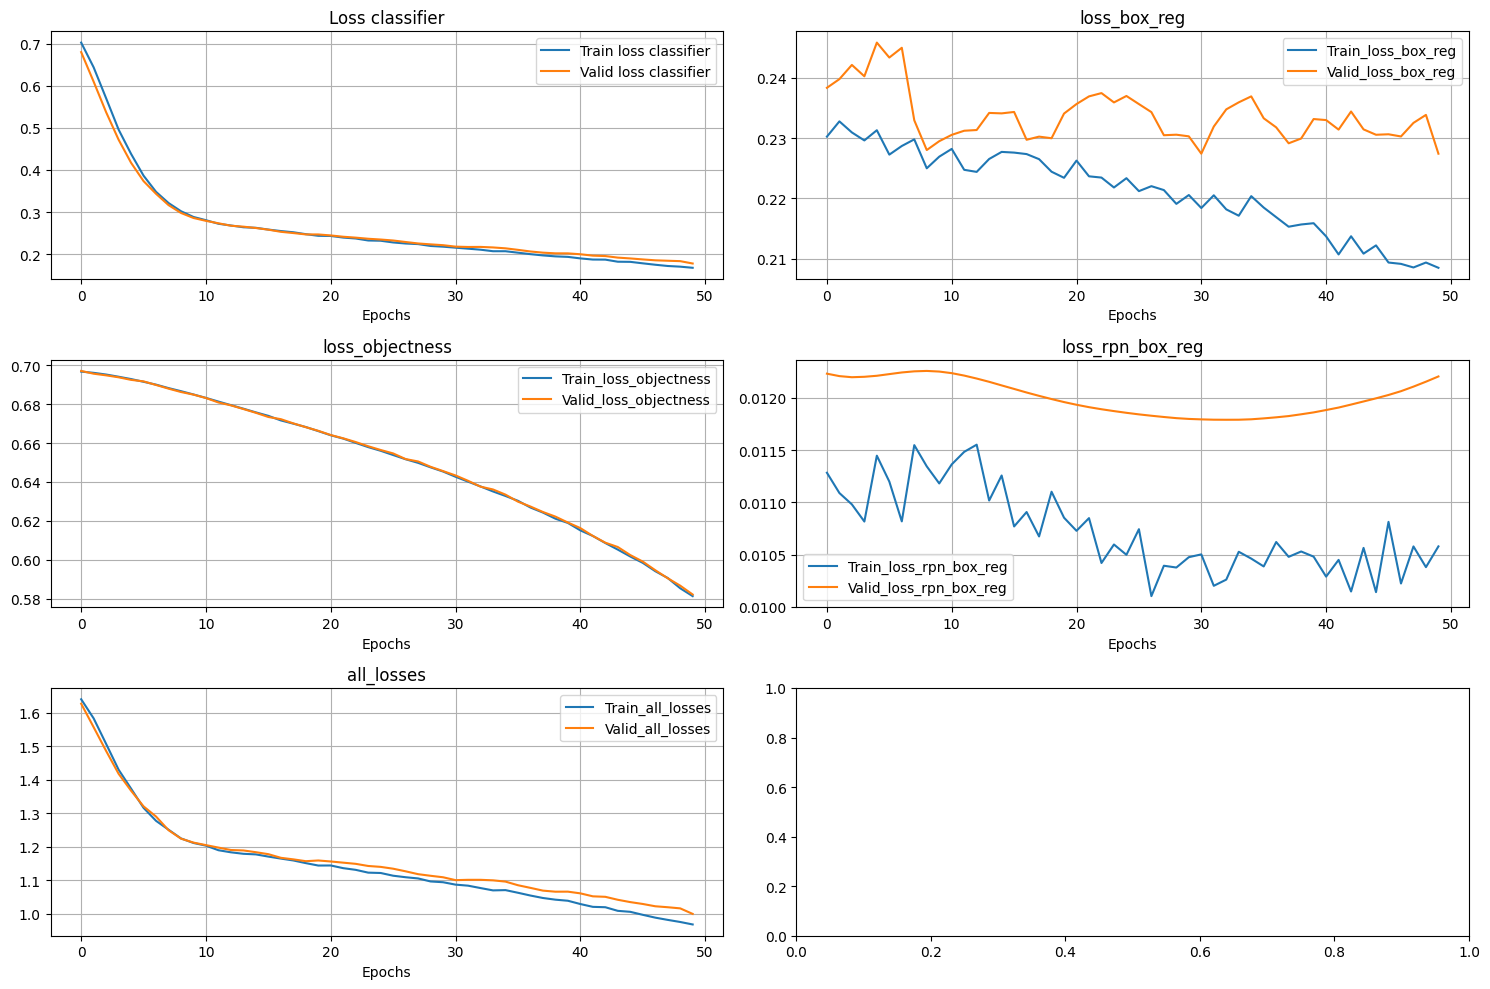

In [18]:
Train_loss_classifier =  [0.7022676808493478, 0.6435030783925738, 0.5700888889176505, 0.4957223321710314, 0.4380145115511758, 0.3863620672907148, 0.3479875198432377, 0.3214789458683559, 0.30197972484997343, 0.2883661261626652, 0.28068050742149353, 0.27223842058862957, 0.2681088319846562, 0.26392796635627747, 0.26262881074632916, 0.25842584456716267, 0.2549425108092172, 0.25207194685935974, 0.24752781646592276, 0.24363975865500315, 0.24325247960431234, 0.23942698538303375, 0.23725316992827825, 0.2325313240289688, 0.23193257408482687, 0.22788016072341374, 0.22534407249518804, 0.22394126653671265, 0.21952798536845616, 0.21783751675060817, 0.21546450895922525, 0.21308631556374685, 0.2106802271945136, 0.2070648627621787, 0.20703312754631042, 0.20358493072646006, 0.2000971862248012, 0.19709803376879012, 0.194827567253794, 0.19361362712723867, 0.19001260186944688, 0.18729065784386226, 0.18710232632500784, 0.18213542657239096, 0.18182497365134104, 0.17830371218068258, 0.17498062125274114, 0.17200306057929993, 0.17040395736694336, 0.16771418494837625]
Valid_loss_classifier =  [0.6796741485595703, 0.6094415783882141, 0.5370031595230103, 0.47174307703971863, 0.41689038276672363, 0.37341830134391785, 0.343295693397522, 0.31651678681373596, 0.2978585958480835, 0.2859457731246948, 0.27912279963493347, 0.27335479855537415, 0.2675664722919464, 0.26533812284469604, 0.26214781403541565, 0.25820428133010864, 0.25312572717666626, 0.2501571774482727, 0.24693070352077484, 0.24685800075531006, 0.24449890851974487, 0.2414231300354004, 0.23928816616535187, 0.23664450645446777, 0.23480676114559174, 0.23248685896396637, 0.22891664505004883, 0.22547554969787598, 0.22331640124320984, 0.2213788479566574, 0.21791505813598633, 0.21713078022003174, 0.21729439496994019, 0.21602781116962433, 0.2139284312725067, 0.2103167027235031, 0.20642799139022827, 0.20364166796207428, 0.20202749967575073, 0.20193861424922943, 0.19984731078147888, 0.19656653702259064, 0.19557547569274902, 0.19187988340854645, 0.18993163108825684, 0.1875852793455124, 0.18547500669956207, 0.18445515632629395, 0.18349912762641907, 0.17789888381958008]
Train_loss_box_reg =  [0.2302297673055104, 0.23275675731045858, 0.23092585802078247, 0.22960454438413894, 0.23129220732620784, 0.22725359669753484, 0.228681675025395, 0.22977842816284724, 0.2249916706766401, 0.22691422062260763, 0.22820161283016205, 0.2247385552951268, 0.22439653745719365, 0.2265321889093944, 0.2277046548468726, 0.2275888259921755, 0.22734418298516954, 0.22650296773229325, 0.22442523283617838, 0.22341622837952205, 0.22626626278672898, 0.2236630299261638, 0.2234545030764171, 0.22181401082447597, 0.22335287928581238, 0.22121040097304753, 0.22203174659184047, 0.22138622190271104, 0.219101967556136, 0.22056451865604945, 0.21841529224600112, 0.2205221951007843, 0.21819079773766653, 0.21714270114898682, 0.2203833907842636, 0.2184900449854987, 0.21690303087234497, 0.21532125983919417, 0.21569072348730906, 0.21590206027030945, 0.21372507299695695, 0.2107315787247249, 0.2137396995510374, 0.21086498669215611, 0.21222821090902602, 0.20939226235662187, 0.20917063738618577, 0.20857525510447367, 0.20939355024269649, 0.20852132780211313]
Valid_loss_box_reg =  [0.23831525444984436, 0.23975102603435516, 0.24210134148597717, 0.24022018909454346, 0.2457980215549469, 0.24332411587238312, 0.24494148790836334, 0.23293454945087433, 0.2280106246471405, 0.22947686910629272, 0.230524942278862, 0.23120753467082977, 0.2313259243965149, 0.23415516316890717, 0.23408254981040955, 0.23431535065174103, 0.22971203923225403, 0.23023328185081482, 0.22996675968170166, 0.2340509593486786, 0.23562709987163544, 0.23689401149749756, 0.23743808269500732, 0.2358950674533844, 0.23696227371692657, 0.23562057316303253, 0.23428964614868164, 0.230464905500412, 0.23055242002010345, 0.23028090596199036, 0.2274104654788971, 0.23190023005008698, 0.23474641144275665, 0.23590734601020813, 0.2368955761194229, 0.23327088356018066, 0.2317664474248886, 0.2291296273469925, 0.22992154955863953, 0.23314332962036133, 0.2329743355512619, 0.23139555752277374, 0.2343895584344864, 0.23143213987350464, 0.2305414378643036, 0.23062224686145782, 0.23026049137115479, 0.23250757157802582, 0.23383060097694397, 0.22740541398525238]
Train_loss_rpn_box_reg =  [0.011284602539879935, 0.011090392645980631, 0.01098165022475379, 0.010817574869309152, 0.011447786087436336, 0.011199971660971642, 0.010819070107702698, 0.011548720034105437, 0.01134556531906128, 0.011182184996349471, 0.011364390807492393, 0.011484437489083834, 0.011553042967404639, 0.01101879682391882, 0.011258236531700407, 0.010770635147179877, 0.01090853355292763, 0.01067488214799336, 0.011102788948587008, 0.010854300111532211, 0.01072886014091117, 0.010850287042558193, 0.010420932567545347, 0.010597943195274897, 0.01049925506647144, 0.010744405112096242, 0.010103871247598104, 0.01039465849420854, 0.010377550231558936, 0.010476595456046718, 0.010503357941550868, 0.01020260195114783, 0.010261986670749528, 0.010528297961822577, 0.010462958099586623, 0.010387987164514405, 0.010621669569185801, 0.010479805458869253, 0.010531093260007245, 0.010481661318668298, 0.010290499510509627, 0.010450587474874087, 0.010148255420582635, 0.010565349832177162, 0.010142021546406406, 0.010814685374498367, 0.01022471021860838, 0.010579510192785944, 0.01038118704621281, 0.010579862897949559]
Valid_loss_rpn_box_reg =  [0.01223248615860939, 0.012209134176373482, 0.01219860091805458, 0.012202656827867031, 0.012212395668029785, 0.01222834549844265, 0.012244158424437046, 0.012254863046109676, 0.012258782982826233, 0.01225269865244627, 0.01223743800073862, 0.01221425086259842, 0.01218588836491108, 0.01215466856956482, 0.012120229192078114, 0.012086481787264347, 0.012052302248775959, 0.012020188383758068, 0.011989635415375233, 0.011960789561271667, 0.011935065500438213, 0.011911995708942413, 0.011892152950167656, 0.011874421499669552, 0.011857960373163223, 0.01184302568435669, 0.0118299825116992, 0.011817988939583302, 0.0118069713935256, 0.01179951149970293, 0.011795122176408768, 0.011792091652750969, 0.011791489087045193, 0.0117918960750103, 0.01179600041359663, 0.011804641224443913, 0.011814884841442108, 0.011826834641397, 0.011843813583254814, 0.011861965991556644, 0.011884582228958607, 0.011908253654837608, 0.011936897411942482, 0.011966540478169918, 0.01199649553745985, 0.012028669007122517, 0.01206493005156517, 0.012108633294701576, 0.012155762873589993, 0.012205870822072029]
Train_loss_objectness =  [0.6967138307435172, 0.6960791008813041, 0.6952072807720729, 0.6940766402653286, 0.692879217011588, 0.6914800575801304, 0.6900133064814976, 0.6882378714425224, 0.686651349067688, 0.6849611401557922, 0.6831948501723153, 0.681309631892613, 0.679479352065495, 0.6776532190186637, 0.6757548025676182, 0.6739749823297773, 0.6716233917645046, 0.669960618019104, 0.6682219931057521, 0.6661374654088702, 0.6639981695583889, 0.6622845104762486, 0.6600780742509025, 0.6579018916402545, 0.6560231021472386, 0.6538336787905011, 0.6516704559326172, 0.6498122726167951, 0.6475034526416233, 0.6453570808683123, 0.6426654372896466, 0.6401647414479937, 0.6376909954207284, 0.6351236956460136, 0.6327987483569554, 0.630318420273917, 0.6268622619765145, 0.6242710522242955, 0.6211281333650861, 0.618938786642892, 0.6151180693081447, 0.6122407232012067, 0.6086136954171317, 0.6052356106894357, 0.6016884957041059, 0.5984311274119786, 0.5941554989133563, 0.5906440445355007, 0.5853729333196368, 0.5813288262912205]
Valid_loss_objectness =  [0.6970599293708801, 0.695631206035614, 0.6947851181030273, 0.6937867403030396, 0.6924633979797363, 0.691688597202301, 0.6898388862609863, 0.6879580616950989, 0.6862207055091858, 0.6848864555358887, 0.6831264495849609, 0.6808386445045471, 0.6793609857559204, 0.6774744391441345, 0.6755340695381165, 0.6733838319778442, 0.6722669005393982, 0.6701030731201172, 0.6681637763977051, 0.6662782430648804, 0.6641103625297546, 0.662425696849823, 0.660515546798706, 0.6583529710769653, 0.6564264893531799, 0.6546608805656433, 0.651758074760437, 0.6505330204963684, 0.6477927565574646, 0.6455814838409424, 0.6433449387550354, 0.6406027674674988, 0.6375932097434998, 0.636142909526825, 0.6334930062294006, 0.6298811435699463, 0.6273804903030396, 0.6245676279067993, 0.6221947073936462, 0.6191451549530029, 0.6162863373756409, 0.6122729778289795, 0.60878986120224, 0.6065686345100403, 0.6024324297904968, 0.5990853905677795, 0.5946639180183411, 0.5905166268348694, 0.5867101550102234, 0.5821638107299805]
Train_all_losses =  [1.6404958622796195, 1.583429319517953, 1.5072036811283656, 1.430221097809928, 1.37363372530256, 1.3162957089287894, 1.2775015660694666, 1.2510439668382918, 1.2249682801110404, 1.2114236525126867, 1.2034413473946708, 1.189771022115435, 1.1835377386638097, 1.1791321890694755, 1.1773465020315987, 1.1707603250231062, 1.164818627493722, 1.1592103924070085, 1.1512778486524309, 1.1440477541514806, 1.1442457437515259, 1.1362248148236955, 1.1312066657202584, 1.12284517288208, 1.1218077966145106, 1.113668646131243, 1.1091501372201102, 1.1055344172886439, 1.0965109722954887, 1.0942357267652238, 1.0870486157281058, 1.083975877080645, 1.0768239838736398, 1.0698595557894026, 1.0706782511302404, 1.0627813509532384, 1.0544841630118233, 1.0471701622009277, 1.0421775238854545, 1.0389361381530762, 1.0291462625776018, 1.0207135677337646, 1.019603967666626, 1.0088013751166207, 1.005883710724967, 0.9969417878559658, 0.9885314617838178, 0.9818018759999957, 0.9755516222545079, 0.9681442039353507]
Valid_all_losses =  [1.627281904220581, 1.5570330619812012, 1.4860881567001343, 1.4179526567459106, 1.3673641681671143, 1.3206593990325928, 1.2903201580047607, 1.2496641874313354, 1.224348783493042, 1.2125617265701294, 1.2050116062164307, 1.1976152658462524, 1.1904393434524536, 1.1891224384307861, 1.183884620666504, 1.1779899597167969, 1.1671569347381592, 1.1625137329101562, 1.1570508480072021, 1.1591479778289795, 1.156171441078186, 1.152654767036438, 1.1491340398788452, 1.1427669525146484, 1.1400535106658936, 1.1346113681793213, 1.1267943382263184, 1.1182913780212402, 1.1134685277938843, 1.10904061794281, 1.1004656553268433, 1.1014257669448853, 1.1014254093170166, 1.099869966506958, 1.0961129665374756, 1.0852733850479126, 1.0773897171020508, 1.069165825843811, 1.0659875869750977, 1.0660890340805054, 1.0609925985336304, 1.0521433353424072, 1.050691843032837, 1.0418472290039062, 1.0349019765853882, 1.0293216705322266, 1.0224642753601074, 1.0195881128311157, 1.0161956548690796, 0.9996740221977234]

# Crear una figura y una cuadrícula de subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Acceder a cada subplot individualmente y graficar
axs[0, 0].plot(Train_loss_classifier, label="Train loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].plot(Valid_loss_classifier, label="Valid loss classifier")  # Subplot en la posición (0, 0)
axs[0, 0].set_title('Loss classifier')
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(Train_loss_box_reg, label="Train_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].plot(Valid_loss_box_reg, label="Valid_loss_box_reg")  # Subplot en la posición (0, 0)
axs[0, 1].set_title('loss_box_reg')
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(Train_loss_objectness, label="Train_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].plot(Valid_loss_objectness, label="Valid_loss_objectness")  # Subplot en la posición (0, 0)
axs[1, 0].set_title('loss_objectness')
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(Train_loss_rpn_box_reg, label="Train_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].plot(Valid_loss_rpn_box_reg, label="Valid_loss_rpn_box_reg")  # Subplot en la posición (0, 0)
axs[1, 1].set_title('loss_rpn_box_reg')
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].grid()
axs[1, 1].legend()

axs[2, 0].plot(Train_all_losses, label="Train_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].plot(Valid_all_losses, label="Valid_all_losses")  # Subplot en la posición (0, 0)
axs[2, 0].set_title('all_losses')
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].grid()
axs[2, 0].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

#### Hacemos inferencias

- Cargamos el modelo

In [26]:
MovilNetV3 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=None)
MovilNetV3.to(device)
num_classes = 2  # 1 class (TV) + background
# get number of input features for the classifier
in_features = MovilNetV3.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
MovilNetV3.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
MovilNetV3.to(device)

MovilNetV3.load_state_dict(torch.load("Movilnet25.pt", map_location=torch.device('cpu')))
MovilNetV3.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [27]:
with torch.no_grad():

    target = test_dataset[1]
    image = target[0]#.permute(1, 2, 0)
    #image = torch.tensor(image * 255, dtype=torch.uint8)
    #print("image shape: ", image.shape)
    y_pred = MovilNetV3([image.to(device)])
    pred = y_pred[0]

    print("y_pred[0]: ", y_pred[0]['scores'])

y_pred[0]:  tensor([0.9325, 0.1073, 0.0672])


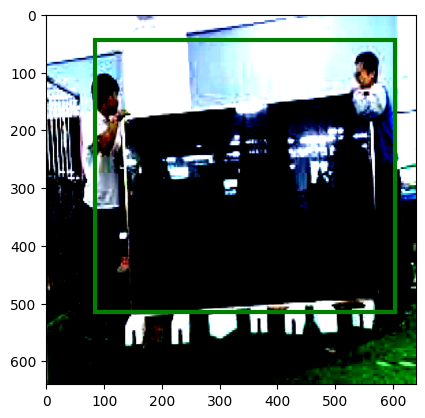

In [28]:
fig, ax = plt.subplots(1)
ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Muestra la imagen

for i, box in enumerate(y_pred[0]['boxes']):

    if y_pred[0]['scores'][i] > 0.5:
        x, y, w, h = box
        rect = patches.Rectangle((int(x), int(y)), int(w) - int(x), int(h) - int(y), linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

plt.show()

C:\Users\franco\AppData\Local\Temp\ipykernel_8904\262198637.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img * 255, dtype=torch.uint8)


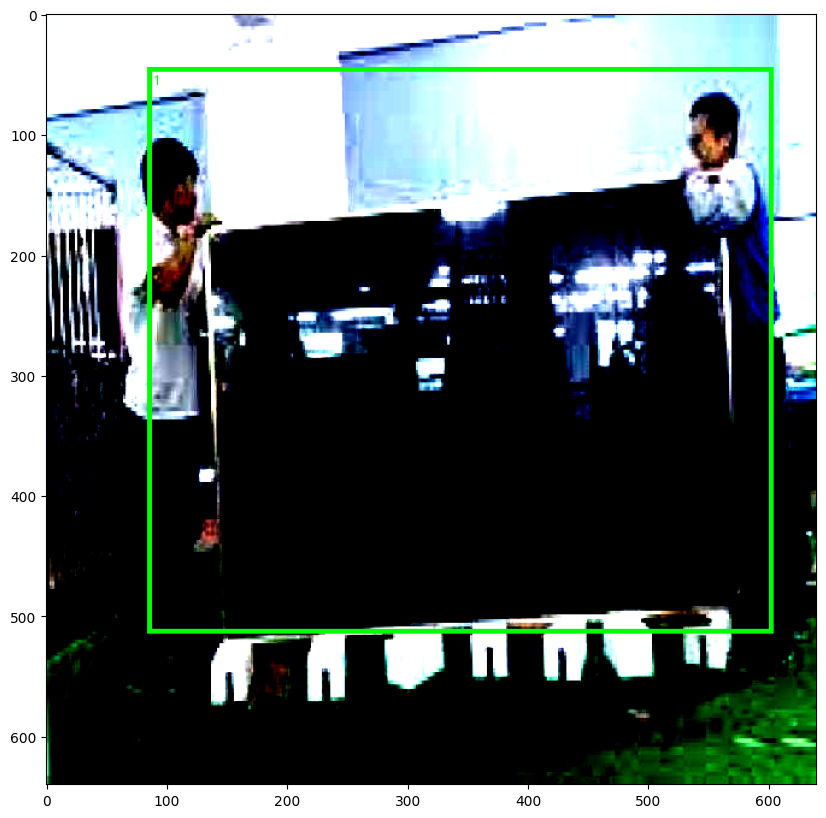

In [29]:
from torchvision.utils import draw_bounding_boxes

img, _ = test_dataset[1]
img_int = torch.tensor(img * 255, dtype=torch.uint8)
with torch.no_grad():
    prediction = MovilNetV3([img.to(device)])
    pred = prediction[0]

fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int, 
                               pred['boxes'][pred['scores'] > 0.5], 
                               [f"{i}" for i in pred['labels'][pred['scores'] > 0.5].tolist()],
                               colors = (0, 255, 0),
                               width=4).permute(1, 2, 0)
          )

#### Fotos caseras

(-0.5, 1598.5, 1355.5, -0.5)

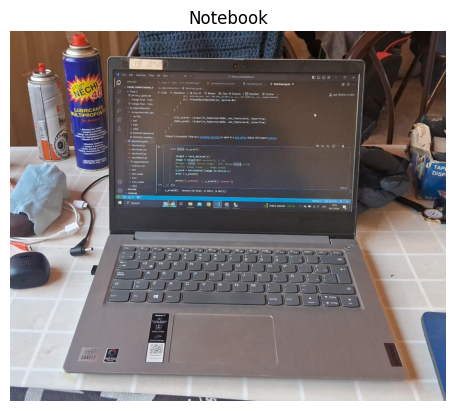

In [30]:
# leemos la imagen
mi_notebook_imagen = Image.open("Mi_notebook.jpeg")
plt.imshow(mi_notebook_imagen)
plt.title("Notebook")
plt.axis('off')

In [31]:
# aplicamos las transformaciones
mi_notebook_imagen_tensor = valid_transform(mi_notebook_imagen)

MovilNetV3.eval()

with torch.no_grad():
    prediction = MovilNetV3([mi_notebook_imagen_tensor.to(device)])

    print("Prediciones: ", prediction)

Prediciones:  [{'boxes': tensor([[ 53.1199,   0.0000, 723.1055, 371.2666],
        [154.2374, 246.4613, 754.0000, 626.3860]]), 'labels': tensor([1, 1]), 'scores': tensor([0.4612, 0.0527])}]


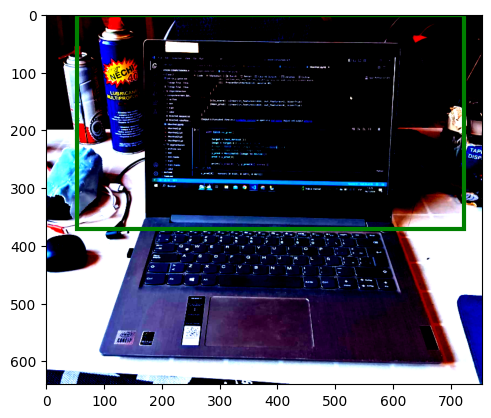

In [32]:
fig, ax = plt.subplots(1)
ax.imshow(mi_notebook_imagen_tensor.permute(1, 2, 0).cpu().numpy())  # Muestra la imagen

for i, box in enumerate(prediction[0]['boxes']):

    if y_pred[0]['scores'][i] > 0.45:
        x, y, w, h = box
        rect = patches.Rectangle((int(x), int(y)), int(w) - int(x), int(h) - int(y), linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

plt.show()

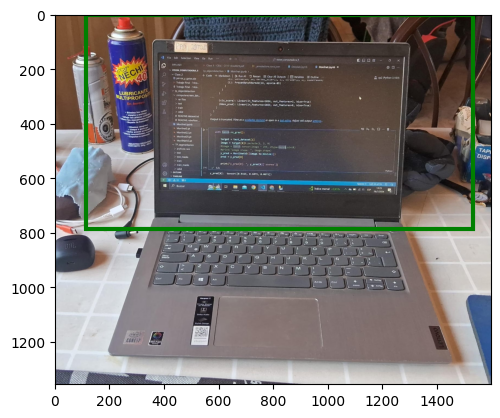

In [33]:
fig, ax = plt.subplots(1)
ax.imshow(mi_notebook_imagen)  # Muestra la imagen

original_img_width, original_img_height = mi_notebook_imagen.size
_, tensor_img_heigth, tensor_img_width = mi_notebook_imagen_tensor.shape

for i, box in enumerate(prediction[0]['boxes']):

    if y_pred[0]['scores'][i] > 0.45:
        x, y, w, h = box
        x2 = (w - x) * original_img_width / tensor_img_width
        x = x * original_img_width  / tensor_img_width
        y2 = (h - y) * original_img_height  / tensor_img_heigth
        y = y * original_img_height  / tensor_img_heigth
        rect = patches.Rectangle((int(x), int(y)), int(x2), int(y2), linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

plt.show()

#### Mean average Precision

In [34]:
# importamos la función que calcula el IoU
from IoU import intersection_over_union
# importamos la función para calcular el mAP
from map import mean_average_precision
from collections import Counter 

In [46]:
# lista para almacenar los map de cada imagen
map_list = []

# recorremos las imagenes
for i in tqdm(range(len(valid_dataset))):

    # creamos una lista donde pasaremos los datos verdaderos
    true_boxes = []

    # creamos una lista donde pasaremos los datos calculados
    pred_boxes = []

    # obtenemos la primer imagen
    valid_dict = valid_dataset[i]   

    # armamos la lista de listas
    for j in range(len(valid_dict[1]['boxes'])):

        sub_list = [valid_dict[1]['image_id'].item(), valid_dict[1]['labels'][j].item(), 1, 
                valid_dict[1]['boxes'][j][0].item(), valid_dict[1]['boxes'][j][1].item(), 
                valid_dict[1]['boxes'][j][2].item(), valid_dict[1]['boxes'][j][3].item()]
        # [train_idx, class_prediction, prob_score, x1, y1, x2, y2]

        true_boxes.append(sub_list)

    #print("True boxes: ", true_boxes)

    # hacemos la inferencia
    with torch.no_grad():

        image = valid_dict[0]#.permute(1, 2, 0)
        #image = torch.tensor(image * 255, dtype=torch.uint8)
        #print("image shape: ", image.shape)
        pred_dict = MovilNetV3([image.to(device)])

        # recorremos las predicciones
        for j in range(len(pred_dict[0]['boxes'])):

            sub_list = [i, pred_dict[0]['labels'][j].item(), pred_dict[0]['scores'][j].item(),
                pred_dict[0]['boxes'][j][0].item(), pred_dict[0]['boxes'][j][1].item(), 
                pred_dict[0]['boxes'][j][2].item(), pred_dict[0]['boxes'][j][3].item()] 
            # [train_idx, class_prediction, prob_score, x1, y1, x2, y2]

            pred_boxes.append(sub_list)

        #print("predictions: ", pred_boxes)

        map = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.95, box_format="corners", num_classes=2)

        map_list.append(map)

print(sum(map_list) / len(map_list))

100%|██████████| 71/71 [00:12<00:00,  5.89it/s]

tensor(0.)
